In [1]:
import sys
sys.path.append('../../')

In [2]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [3]:
dataset_path = "../../dataset"
preprocessed_dataset_path = f"{dataset_path}/preprocessed_dataset"

In [2]:
from codes.docs.analysis import data_preprocessing,genetic_file_preprocess
from codes.docs.analysis.nimagen import stats, visualisation, genes

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

### European dataset

In [6]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel2/volumetric/european_volumetric_df_rel2_batch1.csv')

mixed_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel2/volumetric/mixed_volumetric_df_rel2_batch1.csv')

In [7]:
euro_birthweight = pd.read_csv('preprocessed_dataset/birthweight/euro_birthweight_input.csv')
mixed_birthweight = pd.read_csv('preprocessed_dataset/birthweight/mixed_birthweight_input.csv')

In [8]:
european_volumetric_dataset_term = european_volumetric_dataset_term.merge(euro_birthweight,left_on='ID',right_on='Id',how='inner')

In [9]:
mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.merge(mixed_birthweight,left_on='ID',right_on='Id',how='inner')

In [19]:
old_df = mixed_volumetric_dataset_term.copy()
df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(old_df,grouping='segmented')
df['ICV'] = data_preprocessing.Volumes.Imperial.get_segment(old_df,col='column',tissue=['WM','GM','DGM','Ventricle','Brainstem','Cerebellum','CSF']).sum(axis=1)
df['Total_WM'] = data_preprocessing.Volumes.Imperial.get_segment(old_df,col='column',tissue=['WM']).sum(axis=1)

In [17]:
ancestry_list = [f'euro_Anc_PC{i}' for i in range(1,4)]
euro_summary_table = stats.MassUnivariate.print_summary_table(df,
                                                              thresholds = [i for i in df.columns if 'SCZ_PRS' in i],
                                                              cat_independentVar_cols=['sex'],
                                                              cont_independentVar_cols =['GA','PMA','WeightZScore','ICV']+ancestry_list,
                                                              dependentVar_cols=['Imperial 79','Imperial 58','Imperial 12','Total_WM'])

100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.99s/it]


In [18]:
euro_summary_table.to_excel('Supplementary_Table_6A.xlsx')

In [20]:
ancestry_list = [f'mixed_Anc_PC{i}' for i in range(1,6)]
mixed_summary_table = stats.MassUnivariate.print_summary_table(df,
                                                              thresholds = [i for i in df.columns if 'SCZ_PRS' in i],
                                                              cat_independentVar_cols=['sex'],
                                                              cont_independentVar_cols =['GA','PMA','WeightZScore','ICV']+ancestry_list,
                                                              dependentVar_cols=['Imperial 79','Imperial 58','Imperial 12','Total_WM'])

100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.41s/it]


In [21]:
mixed_summary_table.to_excel('Supplementary_Table_6B.xlsx')

In [16]:
ancestry_list = [f'euro_Anc_PC{i}' for i in range(1,4)]
european_mass_univariate = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df,thresholds=[i for i in df.columns if 'SCZ_PRS' in i],cat_independentVar_cols=['sex'],cont_independentVar_cols=['GA','PMA','WeightZScore','ICV']+ancestry_list,dependentVar_cols=[i for i in df.columns if 'Imperial' in i])

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.64it/s]


In [19]:
ancestry_list = [f'mixed_Anc_PC{i}' for i in range(1,6)]
mixed_mass_univariate = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df,thresholds=[i for i in df.columns if 'SCZ_PRS' in i],cat_independentVar_cols=['sex'],cont_independentVar_cols=['GA','PMA','WeightZScore','ICV']+ancestry_list,dependentVar_cols=[i for i in df.columns if 'Imperial' in i])

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.34it/s]


In [60]:
dep,indep = stats.MassUnivariate.prepare_data(df=df,cat_independentVar_cols='sex',dependentVar_cols=['Imperial 79'],col_to_drop=['sex'])

In [1]:
[i for i in indep.columns for n in ['sex'] if n in i]

NameError: name 'indep' is not defined

In [61]:
indep.drop([i for i in ['sex'] if i in indep.columns],axis=1)

,const,sex_male
0,1.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,1
...,...,...
201,1.0,0
202,1.0,1
203,1.0,1
204,1.0,1


In [44]:
test, _ =stats.MassUnivariate.mass_univariate(df=df,cat_independentVar_cols='sex',dependentVar_cols=['Imperial 79'])

In [53]:
stats.MassUnivariate.calculate_R_squared_explained(df,col_to_drop='sex_male',cat_independentVar_cols='sex',dependentVar_cols=['Imperial 79'])

0.16417115162441742

In [17]:
european_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_coef,GA_pval,PMA_coef,PMA_pval,WeightZScore_coef,WeightZScore_pval,ICV_coef,...,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,sex_male_coef,sex_male_pval,threshold
481,Imperial 79,29515.891279,4.391706e-219,-0.618810,0.996620,-1595.540609,2.382858e-11,-189.825086,0.129058,4115.701589,...,0.894013,-57.362881,0.593001,-27.656523,0.793334,-338.225337,0.001985,988.354555,0.000067,SCZ_PRS_0.05
359,Imperial 79,29536.823216,3.747806e-219,0.297036,0.998379,-1621.915836,1.019358e-11,-201.006121,0.107733,4148.311353,...,0.975891,-57.661978,0.591468,-47.435474,0.652030,-325.774564,0.002492,948.795114,0.000125,SCZ_PRS_0.001
542,Imperial 79,29509.909748,8.994793e-219,1.264856,0.993109,-1605.053821,2.014977e-11,-194.422322,0.120830,4116.016094,...,0.844506,-59.500376,0.580262,-23.871374,0.821945,-322.162242,0.003480,999.659099,0.000060,SCZ_PRS_0.1
165,Imperial 58,4088.861656,2.264705e-173,-20.971868,0.547409,-136.172977,1.123228e-02,-37.861776,0.202644,470.281544,...,0.838267,0.157412,0.995097,-26.683136,0.287377,-71.500116,0.004897,125.995403,0.030444,SCZ_PRS_1e-06
226,Imperial 58,4090.262740,2.299772e-173,-20.760712,0.551578,-136.616529,1.098608e-02,-37.345453,0.209126,470.432079,...,0.860458,0.772965,0.975946,-26.069328,0.298713,-70.939084,0.005277,123.347483,0.034149,SCZ_PRS_1e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,Imperial 81,17362.049513,2.072769e-198,-99.133688,0.366421,-506.910147,2.970803e-03,175.394439,0.061695,2051.659757,...,0.878474,-78.844566,0.327698,120.759490,0.128839,-0.903083,0.991131,743.595646,0.000067,SCZ_PRS_0.5
472,Imperial 60,6794.233167,9.666766e-191,25.922774,0.581774,-399.274928,1.128866e-07,35.375624,0.378866,857.012664,...,0.957157,-48.964927,0.157506,18.098841,0.594598,0.291979,0.993305,220.735942,0.005215,SCZ_PRS_0.05
646,Imperial 49,2938.164655,7.554843e-51,9.607931,0.939343,-428.336842,2.854824e-02,-164.473220,0.127413,1163.585469,...,0.800934,178.845761,0.054660,50.945273,0.577031,-0.520199,0.995564,-241.555450,0.252060,SCZ_PRS_1
255,Imperial 14,6597.521985,1.563537e-198,7.254209,0.861778,359.617581,5.725420e-08,53.673325,0.131443,929.322361,...,0.151207,-42.622471,0.165276,78.765775,0.009123,0.132252,0.996508,77.925194,0.260904,SCZ_PRS_0.0001


In [20]:
mixed_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_coef,GA_pval,PMA_coef,PMA_pval,WeightZScore_coef,WeightZScore_pval,ICV_coef,...,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,sex_male_coef,sex_male_pval,threshold
359,Imperial 79,29358.159499,2.838531e-271,78.532454,0.548333,-1760.168792,1.795759e-16,-190.100952,0.076972,4069.643039,...,0.339466,73.377746,0.467131,-49.705431,0.609803,-352.144396,0.000321,897.862632,0.000051,SCZ_PRS_0.001
470,Imperial 58,4055.796832,8.925778e-212,-13.709175,0.666998,-104.452787,3.271060e-02,-33.201076,0.204412,436.534724,...,0.984009,13.760638,0.575792,-13.853141,0.559489,-88.713953,0.001309,125.944827,0.018413,SCZ_PRS_0.05
226,Imperial 58,4060.283698,7.116177e-212,-10.364017,0.744720,-113.176541,1.998757e-02,-33.840776,0.195931,442.749894,...,0.730696,18.945632,0.441617,-9.845430,0.678374,-72.946808,0.001585,117.621365,0.027565,SCZ_PRS_1e-05
348,Imperial 58,4058.933092,8.478306e-212,-13.980106,0.661277,-109.065870,2.542914e-02,-33.813173,0.196511,441.061555,...,0.826084,16.531116,0.501802,-9.396597,0.692416,-74.458416,0.001753,120.126836,0.024515,SCZ_PRS_0.001
531,Imperial 58,4054.408889,1.605821e-211,-13.054966,0.682383,-106.068094,3.027249e-02,-33.719365,0.198043,436.494994,...,0.945478,15.608468,0.526145,-13.314247,0.575385,-89.105009,0.001979,128.519562,0.016438,SCZ_PRS_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,Imperial 40,1828.755833,2.724339e-198,-19.796824,0.226702,9.818294,6.940416e-01,6.869535,0.609079,167.507453,...,0.303861,-3.124601,0.804639,-10.224513,0.401794,0.226325,0.985952,57.773600,0.034965,SCZ_PRS_0.01
128,Imperial 9,1911.860044,1.104816e-211,-10.163497,0.498619,10.596550,6.426053e-01,-14.878717,0.227500,186.006594,...,0.820854,13.988841,0.228648,-12.777037,0.254674,-0.095657,0.992889,37.998759,0.130292,SCZ_PRS_1e-06
652,Imperial 57,3812.268990,3.741355e-206,-48.160168,0.127795,-46.340878,3.368281e-01,10.356456,0.688722,333.483114,...,0.886496,43.943890,0.071944,8.733070,0.710633,-0.203013,0.994632,213.563504,0.000069,SCZ_PRS_1
374,Imperial 11,3968.848271,1.446297e-224,0.928542,0.973122,252.647161,6.602231e-09,-31.960330,0.158784,478.535981,...,0.591327,-0.797988,0.970100,17.864635,0.384771,-0.084787,0.996877,110.152845,0.017193,SCZ_PRS_0.01


In [15]:
european_volumetric_dataset_term = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(european_volumetric_dataset_term,grouping='segmented')
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]

european_volumetric_dataset_term['GM_proportion'] = european_volumetric_dataset_term['GM_sum_Imperial']/european_volumetric_dataset_term['Total_Brain_Volume_Imperial']

european_volumetric_dataset_term['WM_proportion'] = european_volumetric_dataset_term['WM_sum_Imperial']/european_volumetric_dataset_term['Total_Brain_Volume_Imperial']


european_volumetric_dataset_term = stats.MassUnivariate.remove_outliers(european_volumetric_dataset_term,col=['GM_proportion','WM_proportion'],threshold=3,
                                                    remove_schemes='any',percentage_of_outlier=0.1)

# mixed_volumetric_dataset_term = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(mixed_volumetric_dataset_term,grouping='segmented',remove_duplicated=True)
# dependentVar = [
#     i for i in mixed_volumetric_dataset_term.columns
#     if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
# ]

# mixed_volumetric_dataset_term['GM_proportion'] = mixed_volumetric_dataset_term['GM_sum_Imperial']/mixed_volumetric_dataset_term['Total_Brain_Volume_Imperial']

# mixed_volumetric_dataset_term['WM_proportion'] = mixed_volumetric_dataset_term['WM_sum_Imperial']/mixed_volumetric_dataset_term['Total_Brain_Volume_Imperial']


# mixed_volumetric_dataset_term = data_exploration.MassUnivariate.remove_outliers(mixed_volumetric_dataset_term,
#                                                     col=['GM_proportion','WM_proportion'],
#                                                      threshold=3,
#                                                     remove_schemes='any',
#                                                     percentage_of_outlier=0.1)
# mixed_volumetric_dataset_term = data_exploration.MassUnivariate.remove_outliers(mixed_volumetric_dataset_term,subject_ID=['CC00671XX12','CC00508XX13','CC00055XX06'])



KeyError: 'GM_sum_Imperial'

In [15]:
test = data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(european_volumetric_dataset_term,cat_independentVar_cols=['Gender'],
                                                               cont_independentVar_cols=['PMA_vol','GA_vol','Intracranial_Imperial'],dependentVar_cols=dependentVar
                                                              )

In [ ]:
test = data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(european_volumetric_dataset_term,cat_independentVar_cols=['Gender'],
                                                               cont_independentVar_cols=['PMA_vol','GA_vol','Intracranial_Imperial'],dependentVar_cols=dependentVar
                                                              )

<AxesSubplot:>

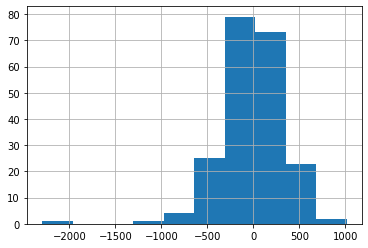

In [18]:
test['Imperial 12'].hist()

<AxesSubplot:>

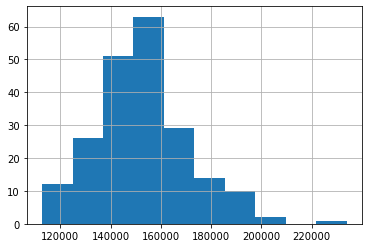

In [17]:
european_volumetric_dataset_term['WM_sum_Imperial'].hist()

<AxesSubplot:>

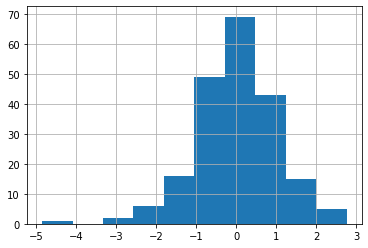

In [105]:
test['Imperial 12'].agg(stats.zscore).hist()

In [62]:
european_volumetric_dataset_term.shape

(290, 154)

In [8]:
imputed_euro_batch2 = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/imputed_data/SCZ3core_nodups_euro_batch2_imputed.gwas.all_score',column_prefix='PRS_',column_suffix='_SCZ_imputed')

no_duplicates_euro_batch2 = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ3core_nodups_euro_batch2_genotyped.gwas.all_score',column_prefix='PRS_',column_suffix='_SCZ_no_dups')



In [9]:
european_volumetric_dataset_term = european_volumetric_dataset_term.merge(imputed_euro_batch2,left_on='ID',right_index=True)

european_volumetric_dataset_term = european_volumetric_dataset_term.merge(no_duplicates_euro_batch2,left_on='ID',right_index=True)

In [9]:
# full_volumetric_dataset_term = data_preprocessing.Volumes.Group_Imperial_volumes(full_volumetric_dataset_term,grouping='segmented',remove_duplicated=True)
# dependentVar = [
#     i for i in full_volumetric_dataset_term.columns
#     if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
# ]
# full_volumetric_dataset_term = data_exploration.MassUnivariate.remove_outliers(full_volumetric_dataset_term,
#                                                     col=['WM_sum_Imperial'],
#                                                      threshold=3,
#                                                     remove_schemes='sum',
#                                                     percentage_of_outlier=0.1)
# full_volumetric_dataset_term = data_exploration.MassUnivariate.remove_outliers(full_volumetric_dataset_term,subject_ID=['CC00671XX12','CC00508XX13','CC00055XX06']) 

In [10]:
# Euro_EastAsian_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_euro_eas_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZ_EuroEastAsianLD')

# Euro_Asian_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_eurasian_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZ_EuroAsianLD')

# Euro_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_eur_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZ_EuroLD')

# noAfr_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_noafr_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZ_NoAfricanLD')

# GWAS_European_Only_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZeuro_eurold_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZeuro_EuroLD')

# european_volumetric_dataset_term = european_volumetric_dataset_term.rename(columns={i:i+'_SCZ_AllLD' for i in european_volumetric_dataset_term.columns if 'PRS' in i})
# european_volumetric_dataset_term = european_volumetric_dataset_term.merge(Euro_EastAsian_PRS,left_on='ID',right_on=Euro_EastAsian_PRS.index)
# european_volumetric_dataset_term = european_volumetric_dataset_term.merge(Euro_Asian_PRS,left_on='ID',right_on=Euro_Asian_PRS.index)
# european_volumetric_dataset_term = european_volumetric_dataset_term.merge(Euro_PRS,left_on='ID',right_on=Euro_PRS.index)
# european_volumetric_dataset_term = european_volumetric_dataset_term.merge(noAfr_PRS,left_on='ID',right_on=noAfr_PRS.index)
# european_volumetric_dataset_term = european_volumetric_dataset_term.merge(GWAS_European_Only_PRS,left_on='ID',right_on=GWAS_European_Only_PRS.index)


In [10]:
# Euro_EastAsian_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_euro_eas_ld_lifted37_dHCP_merged_cleaned_EUROPEAN_ASIAN.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZ_EuroEastAsianLD')

# Euro_Asian_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_eurasian_ld_lifted37_dHCP_merged_cleaned_EUROPEAN_ASIAN.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZ_EuroAsianLD')

# Euro_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_euro_ld_lifted37_dHCP_merged_cleaned_EUROPEAN_ASIAN.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZ_EuroLD')

# noAfr_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_no_afr_ld_lifted37_dHCP_merged_cleaned_EUROPEAN_ASIAN.gwas.all.score',column_prefix='PRS_',column_suffix='_SCZ_NoAfricanLD')

# mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.rename(columns={i:i+'_SCZ_AllLD' for i in mixed_volumetric_dataset_term.columns if 'PRS' in i})
# mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.merge(Euro_EastAsian_PRS,left_on='ID',right_on=Euro_EastAsian_PRS.index)
# mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.merge(Euro_Asian_PRS,left_on='ID',right_on=Euro_Asian_PRS.index)
# mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.merge(Euro_PRS,left_on='ID',right_on=Euro_PRS.index)
# mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.merge(noAfr_PRS,left_on='ID',right_on=noAfr_PRS.index)



In [11]:
print(f'euro:{european_volumetric_dataset_term.shape}')
print(f'mixed:{mixed_volumetric_dataset_term.shape}')

euro:(207, 4495)
mixed:(257, 4585)


/var/folders/2_/td23gmrj5b5g490r04bm1q7h0000gn/T/ipykernel_1341/1728849121.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0][0].set_yticklabels(([int(i) for i in g.axes[0][0].get_yticks()]),size=15)
/var/folders/2_/td23gmrj5b5g490r04bm1q7h0000gn/T/ipykernel_1341/1728849121.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0][0].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)
/var/folders/2_/td23gmrj5b5g490r04bm1q7h0000gn/T/ipykernel_1341/1728849121.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0][1].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)


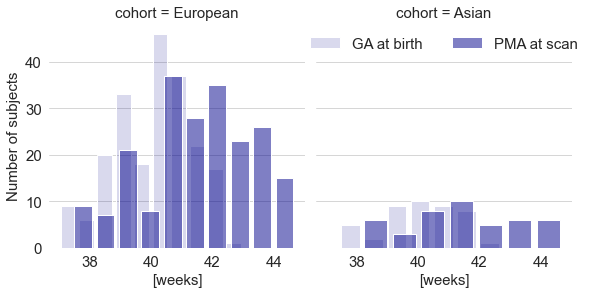

In [10]:
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams["axes.grid.axis"] ="y"
sns.set_style('whitegrid')
g = sns.FacetGrid(mixed_volumetric_dataset_term[['GA_vol','PMA_vol','cohort']],col='cohort',height = 4)
g.map(sns.histplot,'GA_vol',label='GA at birth',color='darkblue',alpha=0.15,shrink=.8)
g.map(sns.histplot,'PMA_vol',label='PMA at scan',color='darkblue',alpha=0.5,shrink=.8)
g.set_ylabels('Number of subjects',fontsize=15)
g.set_xlabels('[weeks]',fontsize=15,fontname='Helvetica')
g.axes[0][0].set_yticklabels(([int(i) for i in g.axes[0][0].get_yticks()]),size=15)
g.axes[0][0].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)
g.axes[0][1].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)


g.axes[0][0].set_title('cohort = European',size=15)
g.axes[0][1].set_title('cohort = Asian',size=15)
plt.legend(ncol=2,loc='upper center',fontsize=15,frameon=False)
sns.despine(bottom=True,left=True)
# g.savefig(f'./{preprocessed_dataset_path}/output_plot/Cohort_age_distribution.pdf',transparent=True)

In [17]:
# to calculate the Veff using matSpdlite. Extract the values, and do
#Remember to set the Imperial volume function above to remove_duplicates = True
df = european_volumetric_dataset_term
euro_GM = data_preprocessing.Volumes.Imperial.extract_GM_Imperial(df)
euro_WM = data_preprocessing.Volumes.Imperial.extract_WM_Imperial(df)
combined = pd.concat([euro_GM,euro_WM],axis=1)
# combined = df[[i for i in df.columns if 'PRS' in i]]
correlation_matrix = np.corrcoef(combined,rowvar=False)
data_exploration.matSpDLite(correlation_matrix,alpha=0.05)

Effective Number of Independent Variables [Veff] is 21.71650651906529
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 13.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0038461538461538438


13.000000000000009

In [10]:
available_PRS = ['_'.join(i.split('_')[2:]) for i in european_volumetric_dataset_term[[i for i in european_volumetric_dataset_term.columns if 'PRS' in i]].columns]
available_PRS = list(set(available_PRS))

In [12]:
temp_dict = defaultdict(dict)
df = european_volumetric_dataset_term
for prs in available_PRS:
    combined = df[[i for i in df.columns if prs in i]]
    correlation_matrix = np.corrcoef(combined,rowvar=False)
    temp_dict['Meff_PRSeuro'][prs] = np.round(data_exploration.matSpDLite(correlation_matrix,alpha=0.05))

df = mixed_volumetric_dataset_term
for prs in available_PRS:
    combined = df[[i for i in df.columns if prs in i]]
    correlation_matrix = np.corrcoef(combined,rowvar=False)
    temp_dict['Meff_PRSmixed'][prs] = np.round(data_exploration.matSpDLite(correlation_matrix,alpha=0.05))

In [33]:
new_temp_dict = pd.DataFrame(temp_dict)

In [39]:
new_temp_dict['P_val_corrected_Euro'] = 0.05/13/new_temp_dict['Meff_PRSeuro']
new_temp_dict['P_val_corrected_Mixed'] = 0.05/13/new_temp_dict['Meff_PRSmixed']

In [40]:
new_temp_dict

,Meff_PRSeuro,Meff_PRSmixed,P_val_corrected_Euro,P_val_corrected_Mixed
SCZ_NoAfricanLD,3.0,4.0,0.001282,0.000962
SCZ_AllLD,3.0,4.0,0.001282,0.000962
SCZeuro_EuroLD,3.0,0.0,0.001282,inf
SCZ_EuroAsianLD,3.0,4.0,0.001282,0.000962
SCZ_EuroEastAsianLD,4.0,3.0,0.000962,0.001282
SCZ_EuroLD,4.0,3.0,0.000962,0.001282


In [15]:
# adding birthweight
euro_birthweight = pd.read_csv(
    './preprocessed_dataset/birthweight/euro_birthweight_input.csv')
# mixed_birthweight = pd.read_csv(
#     './preprocessed_dataset/birthweight/mixed_birthweight_input.csv')

european_volumetric_dataset_term = european_volumetric_dataset_term.merge(
    euro_birthweight, left_on='ID', right_on='Id', how='left')
# mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.merge(
#     mixed_birthweight, left_on='ID', right_on='Id', how='left')

In [69]:
european_volumetric_dataset_term['WeightZScore'] = european_volumetric_dataset_term['WeightZScore'].fillna(0)
mixed_volumetric_dataset_term['WeightZScore'] = mixed_volumetric_dataset_term['WeightZScore'].fillna(0)

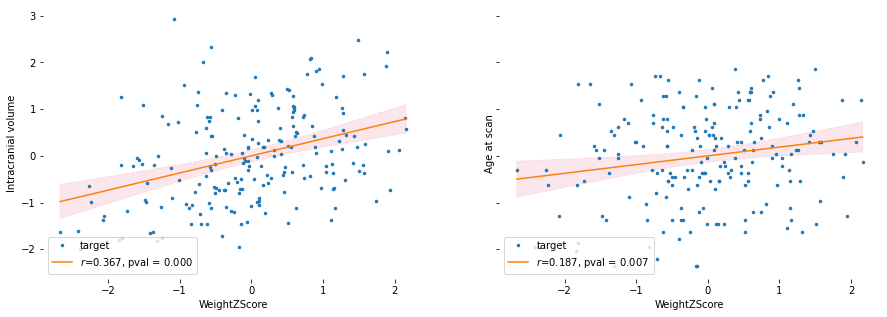

In [20]:
fig,axes = plt.subplots(1,2,sharey=True,figsize=(15,5))
visualisation.simple_plots.plot_Linear_Reg(x='WeightZScore',
                                          y='Intracranial_Imperial',
                                          data=european_volumetric_dataset_term,markersize=5,legend_loc='inside',
                                          ax=axes[0],ylabel='Intracranial volume')
visualisation.simple_plots.plot_Linear_Reg(x='WeightZScore',
                                          y='PMA_vol',
                                          data=european_volumetric_dataset_term,markersize=5,legend_loc='inside',
                                          ax=axes[1],ylabel='Age at scan')
sns.despine(bottom=True,left=True)
fig.savefig('./ICV_Zscore.png')

In [ ]:
df

In [92]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[
        i for i in european_volumetric_dataset_term.columns
        if bool(re.search('Imperial \d',i) or 'WM_sum_Imperial' in i)
    ]
# _, prs_pca, prs_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(df,
#                                                               dependentVar_cols=thresholds,n_components=1,scaling=True)
# df['PRS_no_dups_PCA'] = prs_pca
thresholds = [i for i in df.columns if 'SCZ_PRS' in i]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['Intracranial_Imperial','GA','PMA']+ancestry,
    dependentVar_cols=dependentVar_cols,scaling='both')

# ancestry = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
# df = mixed_volumetric_dataset_term.copy()
# thresholds = [i for i in df.columns if 'SCZ_PRS' in i]

# mixed_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
#     df,
#     thresholds = thresholds,
#     cat_independentVar_cols=['sex'],
#     cont_independentVar_cols=['GA', 'PMA', 'Intracranial_Imperial']+ancestry,
#     dependentVar_cols=dependentVar_cols,scaling='both')
    

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.22it/s]


In [93]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(1)

,Connection,const_coef,const_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,GA_coef,GA_pval,PMA_coef,PMA_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,sex_male_coef,sex_male_pval,threshold
364,Imperial 79,-0.091230,0.011574,1.126974,5.504178e-83,-0.008274,0.784968,-0.412000,2.138547e-17,0.004364,0.862078,-0.018263,0.458029,0.018495,0.456322,-0.086848,0.000515,0.179292,0.000746,SCZ_PRS_Pt_0.001
365,Imperial 80,-0.077640,0.033590,1.129509,4.755442e-82,-0.019752,0.520312,-0.400089,2.942297e-16,-0.014056,0.580737,-0.027523,0.269835,0.015966,0.525454,-0.071767,0.004463,0.152584,0.004487,SCZ_PRS_Pt_0.001
624,Imperial 5,-0.083654,0.122846,0.612842,1.284494e-20,-0.126837,0.005866,0.258775,1.925539e-04,-0.002485,0.948389,-0.044366,0.233377,-0.013295,0.722037,0.094419,0.013512,0.164403,0.038755,SCZ_PRS_Pt_1
29,Imperial 42,-0.023394,0.541762,0.768913,1.237851e-48,-0.056451,0.081858,0.186022,1.434731e-04,-0.026779,0.315850,-0.020033,0.444907,-0.034227,0.196924,0.062686,0.016900,0.045976,0.412933,SCZ_PRS_Pt_1e-08
658,Imperial 51,-0.065873,0.316916,0.557479,5.945590e-13,-0.184464,0.001013,0.187519,2.502365e-02,0.000088,0.998490,-0.067702,0.134922,-0.073557,0.106183,0.109622,0.018257,0.129459,0.179613,SCZ_PRS_Pt_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,Imperial 84,-0.127694,0.142702,0.270118,5.751303e-03,0.141349,0.055140,-0.320355,3.828485e-03,0.054988,0.369863,-0.077356,0.194155,-0.036491,0.543758,0.044473,0.460400,0.250955,0.049471,SCZ_PRS_Pt_0.05
544,Imperial 63,-0.064708,0.259875,0.864288,4.847735e-32,0.017042,0.725086,-0.186414,1.060268e-02,0.043180,0.288807,0.001576,0.968047,0.031743,0.423703,-0.029427,0.463349,0.127169,0.130752,SCZ_PRS_Pt_0.1
258,Imperial 13,-0.070987,0.045346,0.710080,1.431519e-48,-0.018889,0.526475,0.254771,2.810132e-08,0.012723,0.604937,0.000898,0.970300,0.016318,0.504525,0.017376,0.472618,0.139510,0.007423,SCZ_PRS_Pt_0.0001
512,Imperial 19,-0.002355,0.956506,0.803801,2.075635e-43,0.014306,0.694920,0.090261,9.903119e-02,0.007204,0.813952,0.007044,0.812022,-0.038554,0.197176,-0.019877,0.510447,0.004628,0.941634,SCZ_PRS_Pt_0.1


In [84]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(1)

,Connection,const_coef,const_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
364,Imperial 79,0.113275,0.005359,1.102738,1.282273e-63,-0.014938,0.685197,-0.425756,2.795096e-13,0.028067,0.341585,0.004186,0.885483,0.046088,0.117199,-0.102497,0.000475,-0.236232,0.000132,PRS_0.001
365,Imperial 80,0.108727,0.007676,1.104985,1.564504e-63,-0.025781,0.485703,-0.413778,1.260209e-12,0.008523,0.773263,-0.002202,0.939807,0.045304,0.124737,-0.086273,0.003252,-0.226748,0.000249,PRS_0.001
105,Imperial 58,0.103663,0.105327,0.827724,1.690599e-23,-0.092527,0.113419,-0.208065,1.725124e-02,-0.003981,0.931469,-0.012930,0.777478,0.047951,0.302254,-0.128155,0.004796,-0.216187,0.025408,PRS_1e-07
71,Imperial 12,0.035222,0.365853,0.633732,7.415360e-33,-0.034333,0.334552,0.351338,2.127756e-10,-0.004581,0.871075,-0.000632,0.981915,0.025919,0.360320,-0.068427,0.013334,-0.073455,0.211247,PRS_1e-07
521,Imperial 38,-0.004513,0.858680,0.685918,1.243191e-62,-0.003056,0.894971,0.345118,6.724262e-20,0.008035,0.668959,0.010031,0.581522,-0.019338,0.294967,0.045749,0.013694,0.009411,0.805416,PRS_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Imperial 50,-0.014281,0.852995,0.685962,6.759251e-13,-0.170655,0.015903,-0.167265,1.122599e-01,-0.030553,0.593509,0.122206,0.028085,0.009544,0.864775,-0.040469,0.472606,0.029782,0.797848,PRS_0.5
360,Imperial 65,0.151979,0.010784,0.879331,1.031456e-28,-0.088484,0.102637,-0.234744,3.945276e-03,0.028398,0.511742,0.015695,0.712863,0.027419,0.524388,0.027536,0.517054,-0.316948,0.000457,PRS_0.001
316,Imperial 9,0.092138,0.153147,0.644331,1.095762e-15,-0.107731,0.067775,0.103269,2.399872e-01,0.070243,0.136244,0.000679,0.988319,0.048590,0.299786,-0.026806,0.561799,-0.192150,0.048602,PRS_0.001
245,Imperial 84,-0.013330,0.859623,0.730732,6.189817e-15,0.107385,0.119622,-0.225566,2.847805e-02,-0.097494,0.075316,-0.002945,0.956478,0.056114,0.306924,-0.024795,0.642051,0.027800,0.806780,PRS_1e-05


In [22]:
to_plot = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['Connection'].isin(['Imperial 79'])].copy()

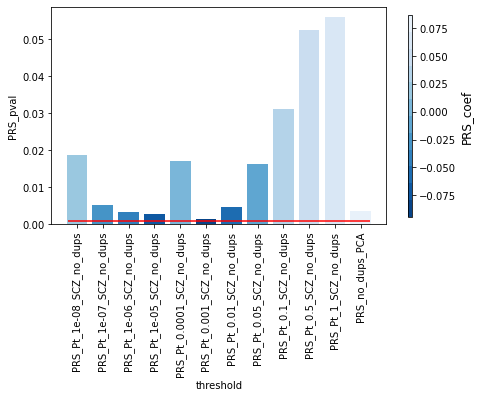

In [23]:
visualisation.simple_plots.Bar(x='threshold',
                              y='PRS_pval',
                               colorby='PRS_coef',
                              data=to_plot,
                               cmap='Blues',
                               cmap_reversed=True,
                               order={'x':thresholds},
                              rotation_x=90,hline=0.00089)

In [10]:
dependentVar_cols=[
        i for i in european_volumetric_dataset_term.columns
        if bool(re.search('Imperial \d',i) or 'WM_sum_Imperial' in i)
    ]

ancestry = ['full_Anc_PC' + str(i) for i in range(1, 11)]
df = full_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]

full_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds = thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']+ancestry,
    dependentVar_cols=dependentVar_cols,scaling='both')
    

100%|████████████████████████| 11/11 [00:01<00:00,  7.15it/s]


In [ ]:
european_volumetric_dataset_term

In [79]:
ancestry = [f'euro_Anc_PC{i}' for i in range(1,4)]
_ = data_exploration.MassUnivariate.mass_univariate(european_volumetric_dataset_term,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['PMA_vol','GA_vol','Intracranial_Imperial','PRS_0.05']+ancestry,
                                               dependentVar_cols=['Imperial 79'],scaling='both')

In [78]:
_[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Imperial 79   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     114.2
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           3.36e-73
Time:                        17:50:51   Log-Likelihood:                -104.63
No. Observations:                 207   AIC:                             229.3
Df Residuals:                     197   BIC:                             262.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1341      0.042      3.162      0.002       0.050       0.218
PMA_vol                  -0.4285      0.061     -7.010      0.000      -0.549      -0.308
GA_vol                   -0.0109      0.040     -0.276      0.783      -0.089       0.067
Intracranial_Imperial     1.1266      0.055     20.364      0.000       1.018       1.236
PRS_0.05                 -0.0934      0.030     -3.141      0.002      -0.152      -0.035
WeightZScore             -0.0474      0.034     -1.396      0.164      -0.114       0.020
euro_Anc_PC1             -0.0040      0.030     -0.131      0.896      -0.064       0.056
euro_Anc_PC2             -0.0161      0.030     -0.546      0.586      -0.074       0.042
euro_Anc_PC3             -0.0070      0.029     -0.242      0.809      -0.064       0.050
Gender_2.0               -0.2832      0.066     -4.280      0.000      -0.414      -0.153
==============================================================================
Omnibus:                        0.808   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.668   Jarque-Bera (JB):                0.525
Skew:                          -0.093   Prob(JB):                        0.769
Kurtosis:                       3.163   Cond. No.                         5.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Adj. PRS_0.001', ylabel='Adj. $FL.R_{WM}$'>

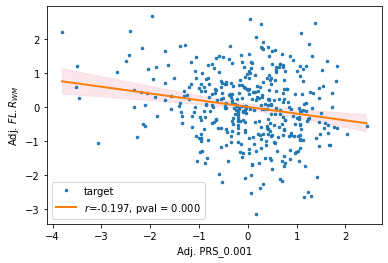

In [14]:
visualisation.simple_plots.plot_Linear_Reg(x='PRS_0.001',
                                          y='Imperial 79',
                                          data=full_volumetric_dataset_term,
                                           adjust_covar={'x':ancestry,
                                                        'y':['Gender','GA_vol', 'PMA_vol', 'Intracranial_Imperial']},
                                           markersize=5,linewidth=2,
                                           ylabel='$FL.R_{WM}$',
                                          legend_loc='inside',)

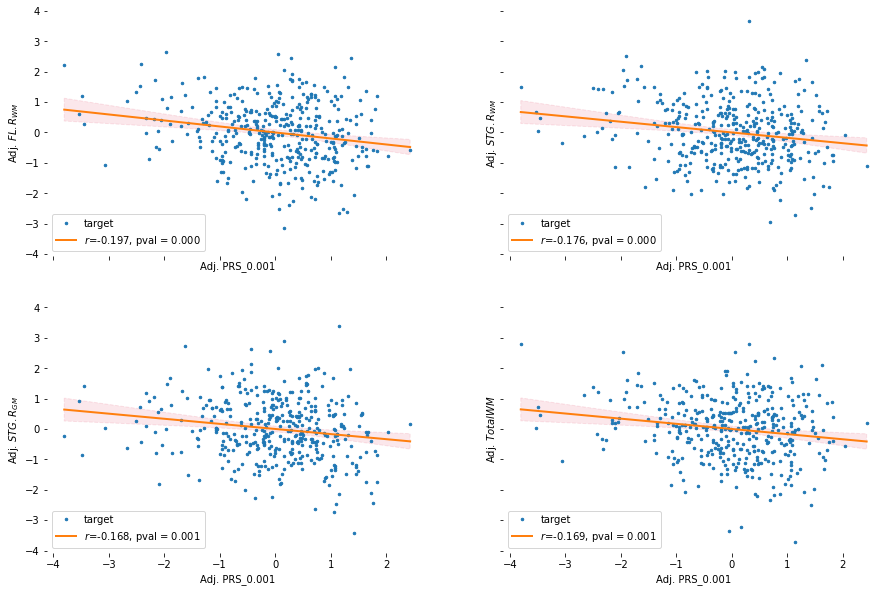

In [16]:
ancestry=[f'full_Anc_PC{i}' for i in range(1,11)]
fig,axes=plt.subplots(2,2,figsize=(15,10),sharex=True,sharey=True)
axes = axes.flatten()
visualisation.simple_plots.plot_Linear_Reg(x='PRS_0.001',
                                          y='Imperial 79',
                                          data=full_volumetric_dataset_term,
                                           adjust_covar={'x':ancestry,
                                                        'y':['Gender','GA_vol', 'PMA_vol', 'Intracranial_Imperial']},
                                           markersize=5,linewidth=2,
                                          legend_loc='inside',
                                           ylabel='$FL.R_{WM}$',
                                          ax=axes[0])
visualisation.simple_plots.plot_Linear_Reg(x='PRS_0.001',
                                          y='Imperial 58',
                                           adjust_covar={'x':ancestry,
                                                        'y':['Gender','GA_vol', 'PMA_vol', 'Intracranial_Imperial']},
                                          data=full_volumetric_dataset_term,markersize=5,linewidth=2,
                                          legend_loc='inside',ax=axes[1],ylabel='$STG.R_{WM}$')
visualisation.simple_plots.plot_Linear_Reg(x='PRS_0.001',
                                          y='Imperial 12',                                           
                                           adjust_covar={'x':ancestry,
                                                        'y':['Gender','GA_vol', 'PMA_vol', 'Intracranial_Imperial']},
                                          data=full_volumetric_dataset_term,
                                           markersize=5,
                                           linewidth=2,ax=axes[2],ylabel='$STG.R_{GM}$',
                                          legend_loc='inside')
visualisation.simple_plots.plot_Linear_Reg(x='PRS_0.001',
                                          y='WM_sum_Imperial',                                           
                                           adjust_covar={'x':ancestry,
                                                        'y':['Gender','GA_vol', 'PMA_vol', 'Intracranial_Imperial']},
                                          data=full_volumetric_dataset_term,
                                           markersize=5,
                                           linewidth=2,ax=axes[3],ylabel='$Total WM$',
                                          legend_loc='inside')
sns.despine(bottom=True,left=True)
fig.savefig('./full_cohort.png',bbox_inches='tight')

In [94]:
mixed_volumetric_dataset_term[mixed_volumetric_dataset_term['Gender']==2]

,ID,Session_vol,GA_vol,PMA_vol,17 ICV (all except bone),17 TOTAL BRAIN TISSUE VOLUME (mm3),"19 Volume Pallidum (Bilateral) AAL, careful with preterm","28 Volume Mesencephalon (right cerebellum) (AAL, careful with preterm!)","28 Volume Mesencephalon (left cerebellum) (AAL, careful with preterm!)","28 Volume Mesencephalon (vermis) (AAL, careful with preterm!)",...,Sex,Length,LengthZScore,LengthCentile,Weight,WeightZScore,WeightCentile,HeadCircumference,HeadCircumferenceZScore,HeadCircumferenceCentile
5,CC00685XX18,226100.0,42.000000,43.285714,537297.375,424983.250,1578.250,11117.375,10924.250,3268.750,...,Female,NaN,NaN,NaN,3.73,0.6401,73.89,NaN,NaN,NaN
6,CC00705XX12,226000.0,39.000000,41.857143,481571.000,397722.375,1345.250,11017.750,10622.125,2853.125,...,Female,NaN,NaN,NaN,3.05,-0.2164,41.43,NaN,NaN,NaN
8,CC00675XX16,219100.0,40.857143,42.000000,485656.625,392918.375,1522.875,10163.625,9546.250,2945.000,...,Female,NaN,NaN,NaN,3.77,0.9865,83.81,NaN,NaN,NaN
9,CC00741XX16,218900.0,41.142857,43.000000,483111.125,407902.000,1460.750,11190.625,10470.875,3110.875,...,Female,NaN,NaN,NaN,4.10,1.6695,95.25,NaN,NaN,NaN
10,CC00656XX13,217601.0,42.285714,43.000000,489210.625,394468.500,1339.750,10526.750,10416.250,3038.375,...,Female,NaN,NaN,NaN,4.20,1.6209,94.75,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,CC00766XX16,4200.0,41.857143,42.000000,442639.375,360125.000,1335.375,10410.125,9897.625,2848.625,...,Female,NaN,NaN,NaN,4.30,1.9004,97.13,NaN,NaN,NaN
253,CC00815XX15,4120.0,37.714286,42.571429,454489.000,381684.875,1337.125,10101.500,9245.125,2742.250,...,Female,NaN,NaN,NaN,2.85,-0.1376,44.53,NaN,NaN,NaN
254,CC00818XX18,4020.0,41.142857,42.571429,495226.750,412848.375,1458.875,11586.625,10824.875,3032.875,...,Female,NaN,NaN,NaN,3.88,1.1983,88.46,NaN,NaN,NaN
255,CC00749XX24,2600.0,40.142857,44.000000,517132.000,425957.875,1457.375,12763.125,12213.750,3459.125,...,Female,NaN,NaN,NaN,3.65,0.9415,82.68,NaN,NaN,NaN


In [95]:
119-98

21

In [98]:
29/50

0.58

In [77]:
p_vals = mixed_volumetric_term_mass_univariate['PRS_pval'].tolist()

In [78]:
_,adjusted_pval = fdrcorrection(p_vals, alpha=0.05, method='indep', is_sorted=False)


In [79]:
np.min(adjusted_pval)

0.09309862246533399

In [74]:
0.05/11/40

0.00011363636363636365

In [76]:
mixed_volumetric_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
364,Imperial 79,0.132517,0.000516,-0.004905,0.888048,-0.456026,4.093381e-16,1.105412,5.702694e-70,-0.018145,...,0.312189,0.022329,0.434146,-0.009512,0.728722,-0.105026,0.000143,-0.286193,0.000002,PRS_0.001
477,Imperial 58,0.129319,0.036893,-0.057905,0.310402,-0.151238,7.946869e-02,0.779950,1.593039e-22,-0.030581,...,0.953137,0.028080,0.547975,-0.021609,0.630499,-0.175147,0.000813,-0.279285,0.004315,PRS_0.05
229,Imperial 58,0.121153,0.050622,-0.050154,0.379389,-0.169420,4.833099e-02,0.792860,3.000119e-23,0.035406,...,0.690284,0.038372,0.412024,-0.013260,0.767764,-0.144775,0.000940,-0.261649,0.007496,PRS_1e-05
353,Imperial 58,0.123291,0.046728,-0.057128,0.317266,-0.161577,6.029169e-02,0.789822,4.541095e-23,0.018650,...,0.788514,0.033582,0.472633,-0.012325,0.783799,-0.148082,0.001015,-0.266267,0.006513,PRS_0.001
319,Imperial 12,0.030966,0.394703,-0.004214,0.900207,0.334169,2.120715e-10,0.654885,4.133946e-38,-0.076514,...,0.632651,-0.021368,0.437717,0.001235,0.962743,-0.086608,0.001095,-0.066877,0.242906,PRS_0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,Imperial 48,-0.087765,0.116302,-0.085410,0.098281,-0.075561,3.292191e-01,0.885448,6.968891e-32,-0.045377,...,0.692411,-0.062152,0.141602,0.047910,0.238086,-0.000617,0.987764,0.189543,0.031445,PRS_0.001
254,Imperial 9,0.095550,0.117938,-0.086991,0.123180,0.105238,2.136134e-01,0.669234,3.319618e-18,-0.039259,...,0.796655,0.057187,0.215923,-0.049123,0.268556,0.000623,0.988479,-0.206356,0.032238,PRS_0.0001
657,Imperial 50,-0.022269,0.775758,-0.160982,0.026475,-0.174144,1.103791e-01,0.644736,1.923729e-11,-0.031039,...,0.820316,-0.067389,0.254871,0.069769,0.221169,-0.000738,0.991937,0.048093,0.696013,PRS_1
640,Imperial 23,-0.023890,0.497494,-0.003348,0.917956,0.294782,6.177799e-09,0.696546,5.192396e-43,0.009660,...,0.252147,-0.016939,0.524650,-0.008256,0.747454,-0.000270,0.993458,0.051595,0.352246,PRS_1


In [73]:
mixed_volumetric_term_mass_univariate[adjusted_pval<0.4]

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
9,Imperial 12,0.031589,0.388388,0.000242,0.994285,0.327303,5.356539e-10,0.659366,3.342772e-38,-0.061711,...,0.516298,-0.020193,0.466319,0.001457,0.956353,-0.069829,0.006477,-0.068223,2.366297e-01,PRS_1e-08
43,Imperial 58,0.124140,0.045974,-0.049424,0.388124,-0.171630,4.627381e-02,0.796371,2.695971e-23,0.042918,...,0.660104,0.035810,0.445425,-0.011624,0.796534,-0.131345,0.002530,-0.268101,6.328921e-03,PRS_1e-08
54,Imperial 79,0.133469,0.000562,0.000421,0.990489,-0.465879,2.271562e-16,1.111853,1.849425e-69,0.000748,...,0.228647,0.023558,0.415920,-0.009535,0.731774,-0.073854,0.005848,-0.288248,2.772240e-06,PRS_1e-08
71,Imperial 12,0.032788,0.369983,-0.000902,0.978688,0.329528,4.116132e-10,0.657035,4.976816e-38,-0.063627,...,0.517694,-0.019924,0.471704,0.000931,0.972055,-0.073028,0.004492,-0.070812,2.186719e-01,PRS_1e-07
105,Imperial 58,0.126395,0.041800,-0.051581,0.366890,-0.167333,5.175913e-02,0.791904,4.005581e-23,0.039240,...,0.662090,0.036330,0.438010,-0.012600,0.779426,-0.138046,0.001535,-0.272970,5.359711e-03,PRS_1e-07
116,Imperial 79,0.134737,0.000491,-0.000785,0.982244,-0.463602,3.001558e-16,1.109444,2.665179e-69,-0.001228,...,0.229205,0.023833,0.409978,-0.010100,0.716189,-0.076777,0.004249,-0.290987,2.184170e-06,PRS_1e-07
133,Imperial 12,0.031575,0.387777,-0.000687,0.983751,0.329619,4.010699e-10,0.656552,5.331409e-38,-0.064405,...,0.528321,-0.020108,0.467425,0.001726,0.948221,-0.074016,0.004036,-0.068191,2.360239e-01,PRS_1e-06
167,Imperial 58,0.124113,0.045557,-0.051172,0.370557,-0.167272,5.177032e-02,0.791076,4.341154e-23,0.037849,...,0.675280,0.035970,0.442413,-0.011117,0.804813,-0.139235,0.001422,-0.268042,6.229046e-03,PRS_1e-06
178,Imperial 79,0.133394,0.000543,-0.000582,0.986809,-0.462867,2.892673e-16,1.108446,2.212319e-69,-0.002507,...,0.235727,0.023710,0.411342,-0.009151,0.741357,-0.081704,0.002362,-0.288087,2.606313e-06,PRS_1e-06
195,Imperial 12,0.029953,0.411822,-0.000144,0.996581,0.328663,4.042071e-10,0.657359,3.349066e-38,-0.065874,...,0.540818,-0.018786,0.496501,0.000604,0.981828,-0.078257,0.002428,-0.064689,2.602318e-01,PRS_1e-05


For the WM the most associated were the White matter Frontal lobe Right (Imperial 79), STG Right (Imperial 58).\
For the GM the most associated were the Grey matter STG Right (Imperial 12)

In [59]:
data_preprocessing.Volumes.extract_WM_Imperial(european_volumetric_term_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(1))

AttributeError: type object 'Volumes' has no attribute 'extract_WM_Imperial'

In [163]:
data_preprocessing.Volumes.extract_WM_Imperial(mixed_volumetric_term_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(1))

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,WeightZScore_coef,...,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
404,Imperial 79,0.121028,0.001702,0.013453,0.711788,-0.487088,2.337223e-16,1.142364,4.451511e-64,-0.050087,...,0.348192,0.020435,0.472831,-0.014549,0.596732,-0.101356,0.000238,-0.261380,2.519705e-05,PRS_0.001
533,Imperial 58,0.115567,0.066190,-0.036179,0.545145,-0.188362,3.990470e-02,0.823976,1.492300e-20,-0.059136,...,0.990038,0.026025,0.577539,-0.027259,0.545872,-0.169356,0.001243,-0.249586,1.318077e-02,PRS_0.05
412,WM_sum_Imperial,0.132008,0.000133,-0.021241,0.513065,-0.349917,1.353229e-11,1.088255,4.849885e-69,-0.001062,...,0.988639,0.024231,0.339898,-0.017994,0.463070,-0.072866,0.002903,-0.285093,3.229085e-07,PRS_0.001
405,Imperial 80,0.110442,0.004382,0.005990,0.870197,-0.473068,1.882851e-15,1.145497,8.698592e-64,-0.048622,...,0.362737,0.026089,0.362779,-0.000446,0.987149,-0.079345,0.004060,-0.238517,1.276367e-04,PRS_0.001
179,Imperial 52,0.050360,0.458570,-0.121199,0.061798,0.209928,3.334872e-02,0.529697,4.599714e-09,0.049274,...,0.327940,0.039901,0.430730,-0.046531,0.341761,-0.104483,0.026281,-0.108761,3.159279e-01,PRS_1e-06
112,Imperial 57,0.201656,0.002267,-0.102077,0.102251,-0.074844,4.292205e-01,0.663467,9.103136e-14,0.028029,...,0.867971,0.091205,0.062340,0.020565,0.662420,-0.100075,0.026905,-0.435509,4.124852e-05,PRS_1e-07
407,Imperial 82,0.182835,0.000201,-0.042662,0.356614,-0.232222,1.083296e-03,0.917691,1.268702e-35,0.048802,...,0.640489,-0.001403,0.969026,-0.014181,0.684654,-0.075661,0.029270,-0.394862,6.521484e-07,PRS_0.001
406,Imperial 81,0.147011,0.002190,-0.043057,0.342563,-0.235500,7.289221e-04,0.938720,8.183864e-38,0.067747,...,0.518843,0.007230,0.838255,-0.030612,0.371418,-0.062562,0.065558,-0.317494,3.882989e-05,PRS_0.001
193,Imperial 76,-0.023344,0.701752,0.044785,0.440569,-0.180301,4.165086e-02,0.878054,7.143856e-24,-0.054300,...,0.896334,-0.007229,0.873547,-0.067328,0.125921,-0.063133,0.133601,0.050415,6.042329e-01,PRS_1e-06
399,Imperial 64,0.097950,0.117853,0.044364,0.456713,-0.300390,1.035176e-03,0.847817,9.455635e-22,0.033218,...,0.222127,0.053759,0.248821,-0.023162,0.606690,-0.065562,0.141565,-0.211540,3.464105e-02,PRS_0.001


In [166]:
ancestry = [f'mixed_Anc_PC{i}' for i in range(1,6)]

data_exploration.MassUnivariate.get_model_summary(df=mixed_volumetric_dataset_term,
                                                 cat_independentVar_cols=['Gender'],
                                                 cont_independentVar_cols=['WeightZScore',
                                                                           'Intracranial_Imperial',
                                                                          'GA_vol','PMA_vol','PRS_0.001']+ancestry,
                                                 dependentVar_cols=['Imperial 12'],scaling='both')

,beta_coefs,pvalues,Rsquared
const,0.015720,6.679358e-01,0.298372
WeightZScore,-0.066468,2.146406e-02,0.003260
Intracranial_Imperial,0.703923,2.161991e-36,0.136221
GA_vol,0.020148,5.642405e-01,0.000203
PMA_vol,0.292948,8.516478e-08,0.018557
PRS_0.001,-0.081737,1.925761e-03,0.005982
mixed_Anc_PC1,-0.071423,1.520702e-02,0.003636
mixed_Anc_PC2,-0.028530,5.562701e-01,0.000211
mixed_Anc_PC3,-0.018745,7.058103e-01,0.000087
mixed_Anc_PC4,-0.023882,3.820365e-01,0.000467


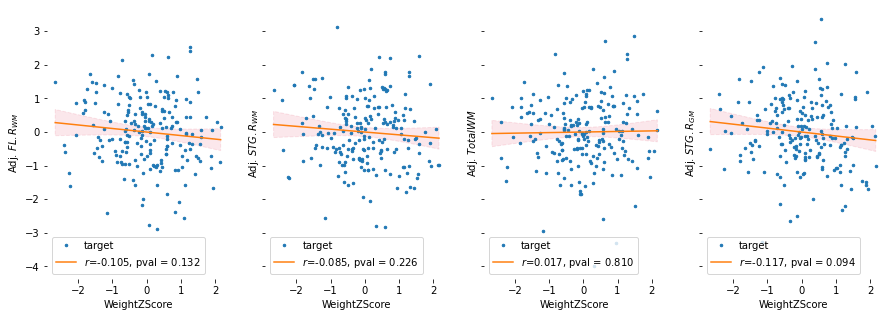

In [22]:
ancestry = [f'euro_Anc_PC{i}' for i in range(1,4)]
fig,axes = plt.subplots(1,4,sharey=True,sharex=True,figsize=(15,5))
df = european_volumetric_dataset_term
axes=axes.flatten()
visualisation.simple_plots.plot_Linear_Reg(x='WeightZScore',
                                           y='Imperial 79',
                                           data=df,
                                           adjust_covar={'y':['Intracranial_Imperial',
                                                             'Gender','GA_vol','PMA_vol']},markersize=5,
                                          legend_loc='inside',ax=axes[0],ylabel='$FL.R_{WM}$')

visualisation.simple_plots.plot_Linear_Reg(x='WeightZScore',
                                           y='Imperial 58',
                                           data=df,
                                           adjust_covar={'y':['Intracranial_Imperial',
                                                             'Gender','GA_vol','PMA_vol']},markersize=5,
                                          legend_loc='inside',ax=axes[1],ylabel='$STG.R_{WM}$')

visualisation.simple_plots.plot_Linear_Reg(x='WeightZScore',
                                           y='WM_sum_Imperial',
                                           data=df,
                                           adjust_covar={'y':['Intracranial_Imperial',
                                                             'Gender','GA_vol','PMA_vol']},markersize=5,
                                          legend_loc='inside',ax=axes[2],ylabel='$Total WM$')

visualisation.simple_plots.plot_Linear_Reg(x='WeightZScore',
                                           y='Imperial 12',
                                           data=df,
                                           adjust_covar={'y':['Intracranial_Imperial',
                                                             'Gender','GA_vol','PMA_vol']},markersize=5,
                                          legend_loc='inside',ax=axes[3],ylabel='$STG.R_{GM}$')
sns.despine(bottom=True,left=True)

# fig.savefig('correlation_withWeight.png',bbox_inches='tight')

In [67]:
df = european_volumetric_dataset_term
model1,_ = data_exploration.MassUnivariate.mass_univariate(df=df,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['GA_vol',
                                                                        'PMA_vol',
                                                                         'Intracranial_Imperial',
                                                                        'PRS_0.05']+ancestry,
                                               dependentVar_cols=['Imperial 12'],scaling='both')

model2,_ = data_exploration.MassUnivariate.mass_univariate(df=df,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['GA_vol',
                                                                        'PMA_vol',
                                                                         'Intracranial_Imperial',
                                                                        'PRS_0.05','WeightZScore']+ancestry,
                                               dependentVar_cols=['Imperial 12'],scaling='both')

In [70]:
model1.aic

222.58208685941946

In [71]:
model2.aic

221.13865903696058

In [56]:
data_exploration.MassUnivariate.mass_univariate

<function codes.docs.analysis.data_exploration.MassUnivariate.mass_univariate(df: Optional[pandas.core.frame.DataFrame] = None, cat_independentVar_cols: Union[List[str], numpy.ndarray, pandas.core.frame.DataFrame, pandas.core.series.Series] = None, cont_independentVar_cols: Union[List[str], numpy.ndarray, pandas.core.frame.DataFrame, pandas.core.series.Series] = None, dependentVar_cols: Union[List[str], numpy.ndarray, pandas.core.frame.DataFrame, pandas.core.series.Series] = None, scaling: str = 'x', col_to_drop: Optional[List[str]] = None, additional_info=None) -> Union[statsmodels.regression.linear_model.RegressionResultsWrapper, pandas.core.frame.DataFrame]>

In [27]:
?data_exploration.MassUnivariate.check_all_predictors_combo_linear_Reg

In [50]:
mixed_volumetric_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
359,Imperial 79,30300.022894,1.339819e-286,0.826476,0.994701,-1636.287504,3.739599e-16,3925.444003,2.925213e-69,-65.007896,...,0.307014,79.110699,0.435153,-30.394992,0.754874,-367.700493,0.000178,-993.321913,0.000004,PRS_0.001
470,Imperial 58,4189.538411,2.625249e-227,-26.907985,0.372996,-83.067042,6.943193e-02,411.611637,2.324943e-22,-16.326999,...,0.947656,14.742291,0.548944,-10.730896,0.649818,-91.918446,0.000839,-142.859816,0.005770,PRS_0.05
226,Imperial 58,4185.725897,4.154289e-227,-23.704075,0.432539,-91.695411,4.415750e-02,417.557890,5.614374e-23,18.438924,...,0.686845,20.135008,0.413546,-6.515676,0.782772,-75.482288,0.001054,-134.588599,0.009318,PRS_1e-05
348,Imperial 58,4186.901451,4.030824e-227,-27.427092,0.364559,-87.473514,5.550792e-02,415.855061,8.783347e-23,9.717934,...,0.784192,17.635435,0.473742,-6.052775,0.797936,-77.178930,0.001149,-137.138952,0.008080,PRS_0.001
481,Imperial 79,30311.462981,7.190437e-286,6.269491,0.960099,-1630.378545,8.447735e-16,3916.325975,2.700661e-68,-156.363879,...,0.398300,67.383994,0.509459,-50.182148,0.609154,-370.414013,0.001182,-1018.141086,0.000003,PRS_0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,Imperial 10,1897.185356,1.376331e-228,-0.017083,0.998990,11.503153,5.719580e-01,209.230285,3.417030e-27,-25.538660,...,0.560902,2.082999,0.849781,14.569029,0.168578,-0.158500,0.988649,-19.733697,0.390689,PRS_0.01
620,Imperial 13,6647.885302,3.855512e-242,86.331169,0.038529,259.616484,4.774797e-05,959.584846,2.638889e-47,-29.577730,...,0.878168,-25.646949,0.448547,13.429874,0.680204,0.478947,0.990861,-33.485274,0.636412,PRS_1
282,Imperial 51,1282.156952,9.855920e-167,-55.059144,0.001013,84.087243,8.528964e-04,114.407167,1.136890e-07,-3.215430,...,0.330654,9.859549,0.465485,-6.959164,0.591728,-0.107137,0.993230,-62.249403,0.028125,PRS_0.0001
647,Imperial 50,2468.656235,7.697535e-79,-175.915990,0.031447,-197.080350,1.099429e-01,720.824122,2.966055e-11,-34.742085,...,0.822430,-75.409774,0.255732,78.404271,0.219976,-0.490780,0.995220,56.265922,0.685134,PRS_1


<AxesSubplot:>

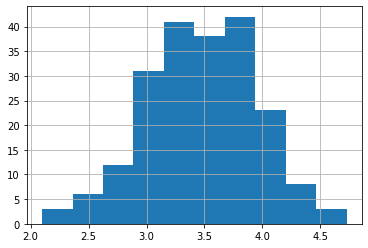

In [27]:
european_volumetric_dataset_term['Birth weight'].hist()

In [42]:
birthweight = mixed_volumetric_dataset_term[['ID','Gender','GA_vol','Birth weight']].copy()
birthweight['Gender'] = ['Male' if i == 1 else 'Female' for i in birthweight['Gender'].tolist()]
birthweight['GA_vol'] = [int(i*7) for i in birthweight['GA_vol'].tolist()]
birthweight.columns = ['ID','Sex','GA','Weight']

In [43]:
birthweight.to_csv('./mixed_birthweight.csv',index=False)

In [44]:
birthweight = pd.read_csv('./mixed_birthweight_input.csv')

In [35]:
birthweight['WeightZScore']

0      1.9173
1     -0.6728
2     -0.2225
3      1.3336
4      0.6401
        ...  
202   -0.4302
203    1.9004
204   -0.1376
205    1.1983
206    0.9415
Name: WeightZScore, Length: 207, dtype: float64

In [45]:
mixed_volumetric_dataset_term = pd.merge(mixed_volumetric_dataset_term,
                                            birthweight[['Id','WeightZScore']],right_on='Id',
         left_on='ID',how='inner')

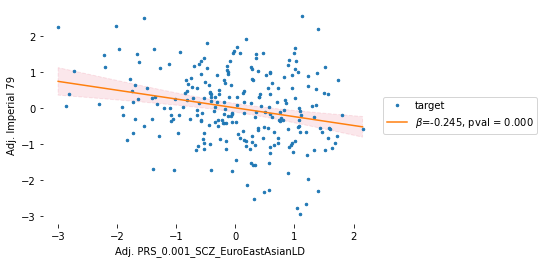

In [43]:
ylabel='Imperial 79'
xlabel = 'PRS_0.001_SCZ_EuroEastAsianLD'
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=[ylabel])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=[xlabel])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel=f'Adj. {xlabel}', ylabel=f'Adj. {ylabel}',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [240]:
PRS_compare = european_volumetric_term_mass_univariate[(european_volumetric_term_mass_univariate['Connection']=='Imperial 79')].copy()

In [241]:
PRS_compare['PRS_p_threshold'] = PRS_compare['threshold'].apply(lambda x: x.split('_')[1])
PRS_compare['LD'] = PRS_compare['threshold'].apply(lambda x: '_'.join(x.split('_')[2:]))

In [242]:
PRS_compare['-log10PRS_pval'] = -np.log10(PRS_compare['PRS_pval'])

In [168]:
0.05/3/13

0.001282051282051282

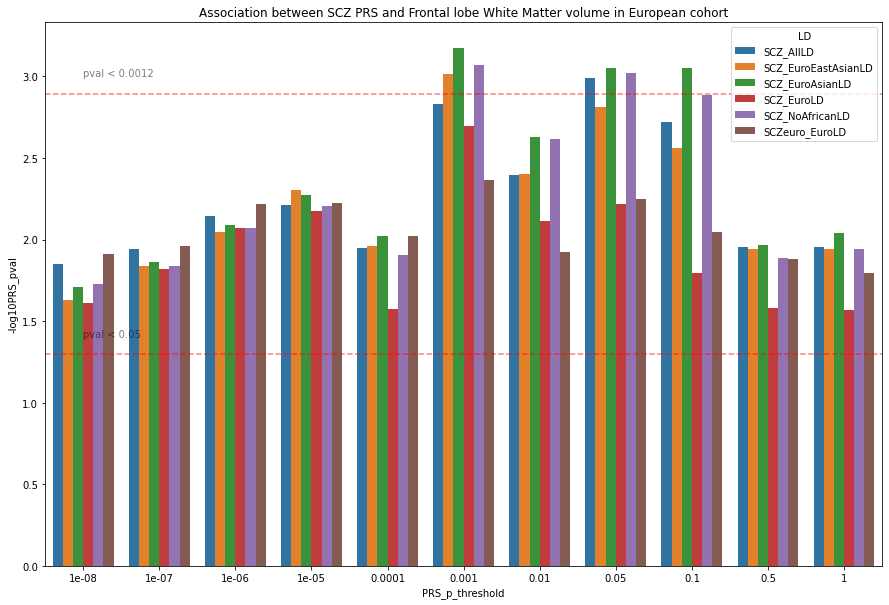

In [247]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(x='PRS_p_threshold',y='-log10PRS_pval',hue='LD',data=PRS_compare,ax=ax)
ax.axhline(-np.log10(0.05/3/13),color='red',alpha=0.5,linestyle='--')
ax.axhline(-np.log10(0.05),color='red',alpha=0.5,linestyle='--')
ax.text(0,3,'pval < 0.0012',alpha=0.5)
ax.text(0,1.4,'pval < 0.05',alpha=0.5)
ax.set_title('Association between SCZ PRS and Frontal lobe White Matter volume in European cohort')
fig.savefig('../../../../../Downloads/european.png',dpi=300)

In [138]:
-np.log10(0.05/6/13)

3.1931245983544616

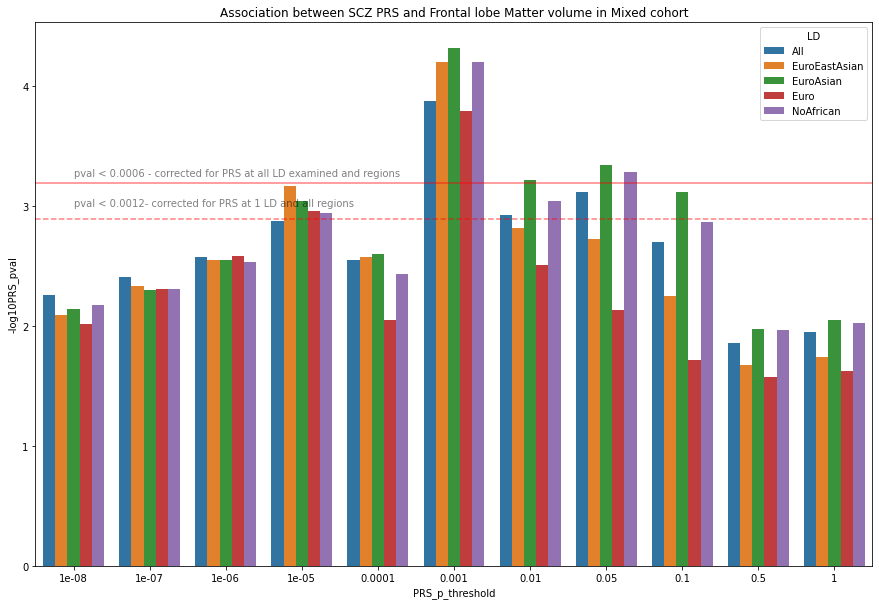

In [164]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(x='PRS_p_threshold',y='-log10PRS_pval',hue='LD',data=PRS_compare,ax=ax)
ax.axhline(-np.log10(0.05/3/13),color='red',alpha=0.5,linestyle='--')
ax.text(0,3,'pval < 0.0012- corrected for PRS at 1 LD and all regions ',alpha=0.5)
ax.axhline(-np.log10(0.05/6/13),color='red',alpha=0.5)
ax.text(0,3.25,'pval < 0.0006 - corrected for PRS at all LD examined and regions',alpha=0.5)

ax.set_title('Association between SCZ PRS and Frontal lobe Matter volume in Mixed cohort')
fig.savefig('../../../../../Downloads/mixed_cohort.png',dpi=300)

In [56]:
data_preprocessing.Volumes.extract_GM_Imperial(european_volumetric_term_mass_univariate).groupby('Connection').head(1).head(5)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
359,Imperial 12,0.041685,0.309993,-0.022635,0.550212,0.352922,2.111079e-09,0.634467,2.929679e-29,-0.025511,0.391618,0.012968,0.656704,0.017823,0.533883,-0.082960,0.004606,-0.088526,0.160413,PRS_0.001
718,Imperial 21,0.093333,0.042641,-0.058962,0.163512,0.248654,1.058079e-04,0.699419,1.947376e-28,-0.025750,0.440726,-0.028092,0.387937,-0.037261,0.247388,-0.065302,0.048522,-0.198212,0.005309,PRS_1
585,Imperial 38,0.003011,0.913725,0.006690,0.794144,0.360314,1.121307e-17,0.666775,9.817841e-51,0.002071,0.918798,-0.014070,0.476441,0.057909,0.003381,0.034651,0.085425,-0.006394,0.880901,PRS_0.1
634,Imperial 5,0.100536,0.123638,-0.095928,0.111119,0.306692,7.212565e-04,0.546516,1.424009e-11,-0.024196,0.610497,-0.080825,0.081553,-0.022420,0.623928,0.075824,0.106466,-0.213510,0.033837,PRS_0.5
369,Imperial 22,0.009719,0.808931,-0.000971,0.979119,0.269962,1.978081e-06,0.708700,5.979802e-35,-0.029211,0.317066,-0.038140,0.183153,-0.000064,0.998176,0.044216,0.120684,-0.020640,0.737850,PRS_0.001


We get the following summary table of R2, beta and p-value of association between PRS and brain volumes

In [14]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=['Imperial 79', 'Imperial 58', 'Imperial 12', 'WM_sum_Imperial'],
                                                    thresholds=thresholds)

In [15]:
summary_table

GA_vol       PMA_vol  \
Imperial 79     PRS_1e-08 R2     2.151483e-07  5.581806e-02   
                          Beta   1.163305e-03 -4.655917e-01   
                          P_val  9.737014e-01  2.193130e-16   
                PRS_1e-07 R2     2.151483e-07  5.581806e-02   
                          Beta  -4.715114e-05 -4.633134e-01   
...                                       ...           ...   
WM_sum_Imperial PRS_0.5   Beta  -2.090412e-02 -3.504964e-01   
                          P_val  4.976230e-01  7.648056e-13   
                PRS_1     R2     2.069066e-04  3.168293e-02   
                          Beta  -2.117077e-02 -3.491695e-01   
                          P_val  4.918391e-01  9.191190e-13   

                                 Intracranial_Imperial  mixed_Anc_PC1  \
Imperial 79     PRS_1e-08 R2              4.345161e-01       0.000042   
                          Beta            1.111430e+00       0.001041   
                          P_val           1.504568e-69       0.972560   
                PRS_1e-07 R2              4.345161e-01       0.000042   
                          Beta            1.109018e+00      -0.000937   
...                                                ...            ...   
WM_sum_Imperial PRS_0.5   Beta            1.092073e+00      -0.000195   
                          P_val           1.989428e-78       0.995132   
                PRS_1     R2              4.196961e-01       0.000481   
                          Beta            1.090843e+00      -0.002398   
                          P_val           2.625290e-78       0.940021   

                                 mixed_Anc_PC2  mixed_Anc_PC3  mixed_Anc_PC4  \
Imperial 79     PRS_1e-08 R2          0.000154       0.001059       0.000422   
                          Beta       -0.029123      -0.063549       0.024028   
                          P_val       0.570351       0.226530       0.406298   
                PRS_1e-07 R2          0.000154       0.001059       0.000422   
                          Beta       -0.028789      -0.063398       0.024302   
...                                        ...            ...            ...   
WM_sum_Imperial PRS_0.5   Beta        0.024430       0.001851       0.022922   
                          P_val       0.585327       0.968076       0.363892   
                PRS_1     R2          0.000128       0.000014       0.000426   
                          Beta        0.024602       0.002582       0.022865   
                          P_val       0.582377       0.955443       0.364681   

                                 mixed_Anc_PC5  Gender  PRS_1e-08  ...  \
Imperial 79     PRS_1e-08 R2          0.000126     0.0   0.000000  ...   
                          Beta       -0.009900     NaN  -0.074038  ...   
                          P_val       0.721709     NaN   0.005687  ...   
                PRS_1e-07 R2          0.000126     0.0        NaN  ...   
                          Beta       -0.010466     NaN        NaN  ...   
...                                        ...     ...        ...  ...   
WM_sum_Imperial PRS_0.5   Beta       -0.020695     NaN        NaN  ...   
                          P_val       0.394847     NaN        NaN  ...   
                PRS_1     R2          0.000294     0.0        NaN  ...   
                          Beta       -0.020826     NaN        NaN  ...   
                          P_val       0.391380     NaN        NaN  ...   

                                 PRS_1e-07  PRS_1e-06  PRS_1e-05  PRS_0.0001  \
Imperial 79     PRS_1e-08 R2           NaN        NaN        NaN         NaN   
                          Beta         NaN        NaN        NaN         NaN   
                          P_val        NaN        NaN        NaN         NaN   
                PRS_1e-07 R2      0.000000        NaN        NaN         NaN   
                          Beta   -0.076941        NaN        NaN         NaN   
...                                    ...        ...        ...         ..

We get the following plots

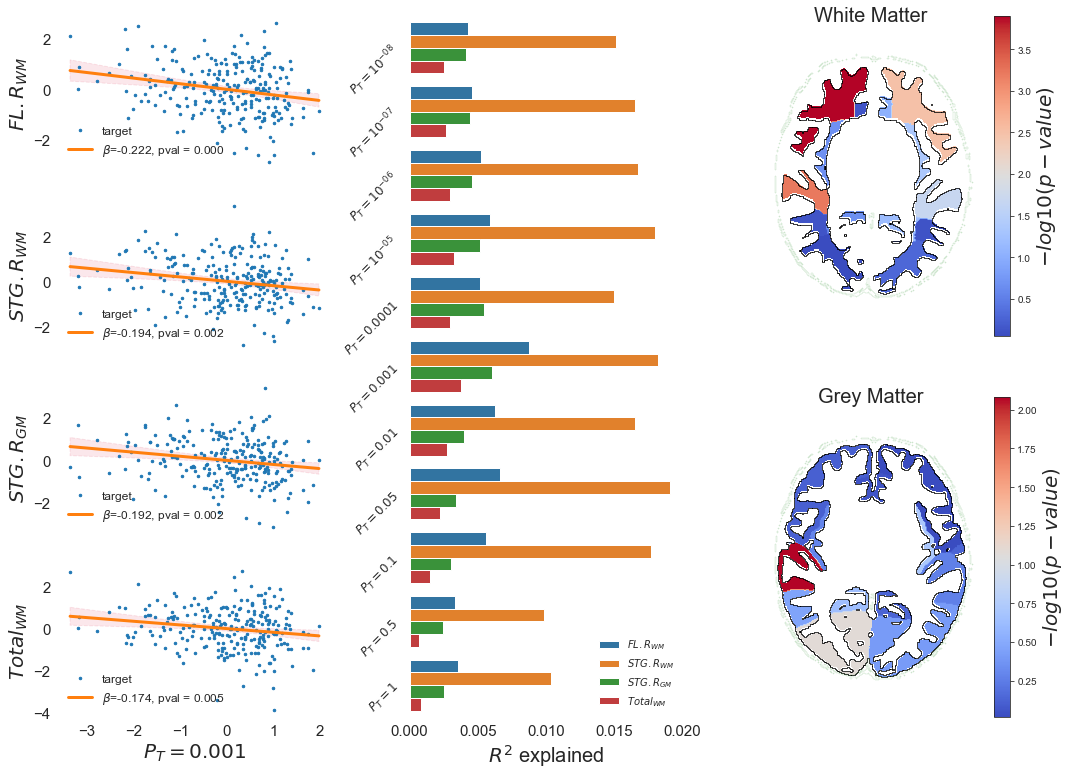

In [138]:
sns.set_style('white')
fig,axes = plt.subplots(4,3,sharex = True,figsize=(15,11))
# fig = plt.figure(figsize=(20,10))
# ax1 = plt.subplot(4,3,1)
# ax2 = plt.subplot(4,3,4)
# ax3 = plt.subplot(4,3,7)
# ax4 = plt.subplot(4,3,10)
for ax in axes[:,1:].flatten():
    ax.remove()
bar_plot = plt.subplot(132)
WM_plot = plt.subplot(233)
GM_plot = plt.subplot(236)
# plt.tight_layout(w_pad =.5, h_pad=.2)
dependent_var = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']
ylbl = ['$FL.R_{WM}$', '$STG.R_{WM}$', '$STG.R_{GM}$','$Total_{WM}$']
threshold = 'PRS_0.001'
thresholds_label = '$P_T = 0.001$'
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1,4)]
# axes = axes.flatten()
df = mixed_volumetric_dataset_term
# draw the scatter plot
for ax,dependent_variable, ylabel in zip(axes[:,0],dependent_var,ylbl):
    model, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                              cat_independentVar_cols=['Gender'],
                                                              cont_independentVar_cols=[
                                                                  'GA_vol','PMA_vol','Intracranial_Imperial'
                                                              ]+ancestry_list,
                                                              dependentVar_cols=[dependent_variable])
    visualisation.plot_Linear_Reg(x = df[[threshold]].values,
                                 y = model.resid.values,
                                 data = df,
                                 ylabel = ylabel,
                                 xlabel = f'{threshold}',
                                 axes=ax,legend_loc='inside',linewidth = 3,markersize=5)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(None,fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=15)
    ax.legend(loc='lower left',fontsize=12,frameon=False)
    sns.despine(bottom=True,left=True,right=True)
axes[-1,0].set_xlabel(f'{thresholds_label}',fontsize=20)

    
#draw the barplot of R-squared explained
Rsquared_explained_list = defaultdict(dict)
for dependent_variable in dependent_var:
    Rsquared_explained_list[dependent_variable] = defaultdict(list)
    for threshold in [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]:
        Rsquared_explained_list[dependent_variable][threshold] = data_exploration.MassUnivariate.calculate_R_squared_explained(df = df,col_to_drop=threshold,cat_independentVar_cols=['Gender'],cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry_list,dependentVar_cols=[dependent_variable])
Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_list)
Rsquared_explained_pd.columns = ylbl

Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_pd.unstack()).reset_index()
Rsquared_explained_pd.columns = ['Region','Threshold','$R^{2}$ explained']

g = sns.barplot(y = 'Threshold',x = '$R^{2}$ explained', data = Rsquared_explained_pd,hue = 'Region',ax = bar_plot)
# g.set_xlabel(rotation=90)
sns.despine(bottom=True,left=True,right=True)
bar_plot.set_xlabel('$R^{2}$ explained',fontsize=20)
bar_plot.set_ylabel(None,fontsize=20)
g.set_yticklabels(['$P_T = 10^{-08}$','$P_T = 10^{-07}$',
                     '$P_T = 10^{-06}$','$P_T = 10^{-05}$',
                     '$P_T = 0.0001$','$P_T = 0.001$',
                     '$P_T = 0.01$','$P_T = 0.05$',
                    '$P_T = 0.1$','$P_T = 0.5$','$P_T = 1$'],fontsize=12,rotation = 45)
g.tick_params(axis='x', labelsize=15)
bar_plot.legend(frameon=False)

#import the atlas
import nibabel as nib
FOLDER_PATH = f'{dataset_path}/visualise/Imperial/'  # please change to your own path

atlas_file = nib.load(FOLDER_PATH + 'atlas_t40.nii.gz')
atlas_aff = atlas_file.affine
atlas = atlas_file.get_fdata()

df = mixed_volumetric_term_mass_univariate[mixed_volumetric_term_mass_univariate['threshold'] == 'PRS_0.001'].copy()

df = df[[bool(re.search(r'[1-9]',i)) for i in df['Connection']]].sort_values(by='PRS_pval').reset_index(drop=True)
df['Connection_ID'] = [int(i.split(' ')[1]) for i in df['Connection']]

# Create a new volume of the same size as the atlas
atlas_coeffs_WM = np.zeros_like(atlas)
atlas_coeffs_GM = np.zeros_like(atlas)


WM_df = extract_WM_Imperial(df).reset_index(drop=True)
GM_df = extract_GM_Imperial(df).reset_index(drop=True)
# fig,axes = plt.subplots(1,2,figsize=(20,10))
# Here you will replace each index (0...87) from the atlas with the coefficients you want to plot
for i in WM_df['Connection_ID'].tolist():
    atlas_coeffs_WM[atlas == i] = -np.log10(WM_df.loc[WM_df['Connection_ID'] == i,'PRS_pval'].values)

for i in GM_df['Connection_ID'].tolist():
    atlas_coeffs_GM[atlas == i] = -np.log10(GM_df.loc[GM_df['Connection_ID'] == i,'PRS_pval'].values)


# im1 = WM_plot.imshow(np.rot90(atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]),cmap='coolwarm')
# im2 = GM_plot.imshow(np.rot90(atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]),cmap='coolwarm')

import copy
from matplotlib.collections import LineCollection

cmap = copy.copy(plt.cm.get_cmap('coolwarm'))
cmap.set_bad(alpha=0)

# atlas_coeffs_WM[atlas==84] = 0.1
WM_atlas = atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]
GM_atlas = atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]

WM_atlas[WM_atlas==0] = np.nan
GM_atlas[GM_atlas==0] = np.nan

im1 = WM_plot.imshow(np.rot90(WM_atlas),cmap=cmap)
im2 = GM_plot.imshow(np.rot90(GM_atlas),cmap=cmap)

WM_atlas[np.isnan(WM_atlas)] = 0
GM_atlas[np.isnan(GM_atlas)] = 0

brain_background = np.zeros(atlas.shape)
brain_background[atlas==84] = 1
brain_background = brain_background[:, :, brain_background.shape[2]//2]

cl_WM = LineCollection(visualisation.get_edges(np.rot90(WM_atlas)),lw=1,color='k')
WM_plot.add_collection(cl_WM)

cl_GM = LineCollection(visualisation.get_edges(np.rot90(GM_atlas)),lw=1,color='k')
GM_plot.add_collection(cl_GM)


cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
WM_plot.add_collection(cl_background)
cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
GM_plot.add_collection(cl_background)

for im,ax in zip([im1,im2],[WM_plot,GM_plot]):
    cbar = plt.colorbar(im,ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar.set_label('$-log10(p-value)$', fontsize=20)
WM_plot.set_title('White Matter',fontsize=20)
GM_plot.set_title('Grey Matter', fontsize=20)
# WM_plot.set_ylabel('White Matter',fontsize=20)
# GM_plot.set_ylabel('Grey Matter',fontsize=20)
plt.tight_layout()
fig.savefig(f'{preprocessed_dataset_path}/output_plot/all_plots_mixed.svg')

# Other tests

## Stability test

1. We halve the sample into 2 equal data sets and see if similar results are given
2. We separate into high and low risks

### Halving the samples

In [45]:
common_list_WM = defaultdict(pd.DataFrame)
common_list_GM = defaultdict(pd.DataFrame)
ancestry = ['mixed_Anc_PC'+str(i) for i in range(1,6)]
df = mixed_volumetric_dataset_term
thresholds = [i for i in mixed_volumetric_dataset_term.columns if 'PRS' in i]
result_dict = defaultdict(dict)
for run in range(10):
    result_dict[f'split_{run+1}']=defaultdict(dict)
    for threshold in thresholds:
        result_dict[f'split_{run+1}'][threshold]=defaultdict(dict)
        result_dict[f'split_{run+1}'][threshold]['Set_1']=defaultdict(dict)
        result_dict[f'split_{run+1}'][threshold]['Set_2']=defaultdict(dict)
        
        train, test = data_exploration.train_test_split_modified(
            df,
            'GA_vol',
            'Gender',
            'cohort',
            random_state=run)
        _,train_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            train, cat_independentVar_cols=['Gender'],
            cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry,
            dependentVar_cols=['WM_sum_Imperial','Imperial 79','Imperial 58','Imperial 12'])

        _,test_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            test, cat_independentVar_cols=['Gender'], cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry,
            dependentVar_cols=['WM_sum_Imperial','Imperial 79','Imperial 58','Imperial 12'])
        train_mass_univariate = train_mass_univariate.rename({threshold+'_pval':'PRS_pval',
                                 threshold+'_coef':'PRS_coef'},axis=1)
        test_mass_univariate = test_mass_univariate.rename({threshold+'_pval':'PRS_pval',
                                 threshold+'_coef':'PRS_coef'},axis=1)
        
        for col,colname in zip(train_mass_univariate.index.tolist(),['Total WM',
                                                                    'FL.R_WM',
                                                                    'STG.R_WM',
                                                                    'STG.R_GM']):
            result_dict[f'split_{run+1}'][threshold]['Set_1'][colname]['p_value'] = train_mass_univariate.loc[col,'PRS_pval']
            result_dict[f'split_{run+1}'][threshold]['Set_1'][colname]['beta'] = train_mass_univariate.loc[col,'PRS_coef']
            result_dict[f'split_{run+1}'][threshold]['Set_2'][colname]['p_value'] = test_mass_univariate.loc[col,'PRS_pval']
            result_dict[f'split_{run+1}'][threshold]['Set_2'][colname]['beta'] = test_mass_univariate.loc[col,'PRS_coef']

In [46]:
halving_samples = pd.DataFrame.from_dict({(s, t, st, bv): result_dict[s][t][st][bv]
                        for s in result_dict.keys()
                        for t in result_dict[s].keys()
                        for st in result_dict[s][t].keys()
                        for bv in result_dict[s][t][st].keys()},orient='index')

In [51]:
#halving_samples.to_excel('halving_samples.xlsx')

### High and low risk

In [146]:
df = mixed_volumetric_dataset_term
ancestry_PCs = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
threshold = 'PRS_0.001'
dependentVar = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']


def high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc):
    high_risk, low_risk = data_exploration.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
            np.asarray(df[threshold]), df[ancestry_PCs]),
        low_perc=perc,
        high_perc=perc)
    temp_high_risk = df.loc[high_risk, dependentVar].reset_index(drop=True)
    temp_high_risk['Percentages'] = perc
    temp_high_risk['Risk'] = 'High'
    temp_low_risk = df.loc[low_risk, dependentVar].reset_index(drop=True)
    temp_low_risk['Percentages'] = perc
    temp_low_risk['Risk'] = 'Low'
    return pd.concat([temp_high_risk, temp_low_risk])


risk_df = pd.concat([
    high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc) for perc in [0.1,0.2,0.3,0.4]])
risk_df = risk_df.reset_index(drop=True)

In [153]:
df = european_volumetric_dataset_term
ancestry_PCs = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
threshold = 'PRS_0.001'
high_risk, low_risk = data_exploration.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
            np.asarray(df[threshold]), df[ancestry_PCs]),
        low_perc=0.1,
        high_perc=0.1)

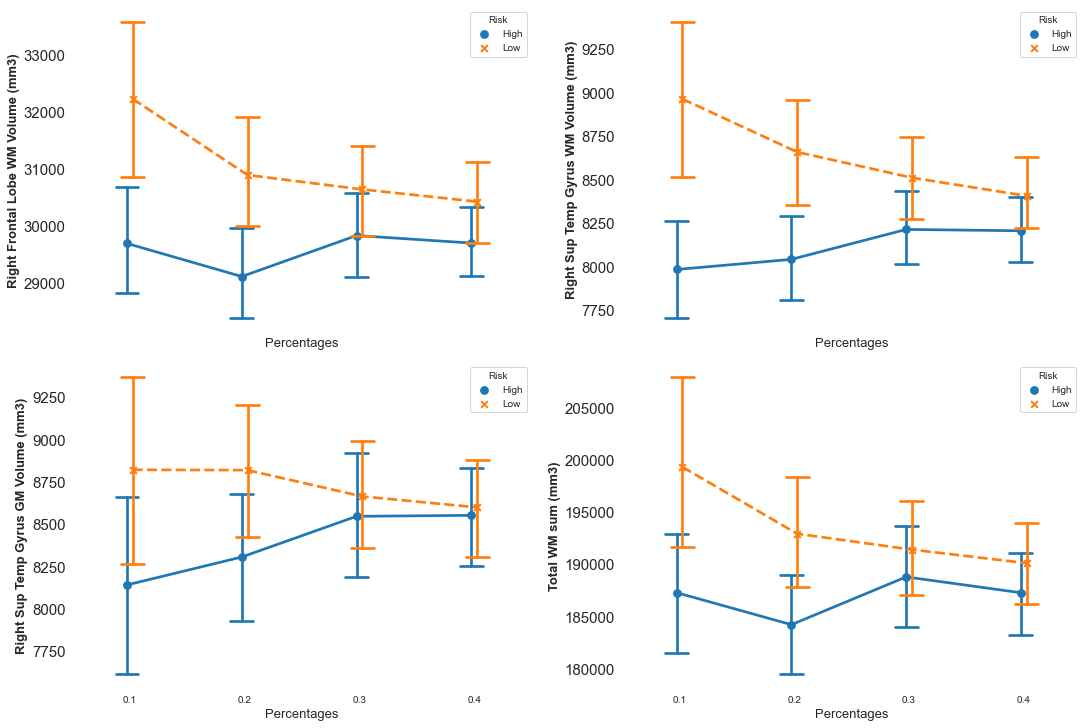

In [144]:
fig,axes = plt.subplots(2,2,figsize=(15,10),constrained_layout=True,sharex=True)
# axes[1,1].remove()
axes = axes.flatten()
for ax, variable,var_name in zip(axes,dependentVar,['Right Frontal Lobe WM Volume (mm3)',
                                                   'Right Sup Temp Gyrus WM Volume (mm3)',
                                                   'Right Sup Temp Gyrus GM Volume (mm3)',
                                                   'Total WM sum (mm3)']):
    sns.pointplot(x='Percentages',
                  y=variable,
                  data=risk_df,
                  hue='Risk',
                  dodge=True,
                 markers=['o','x'],
                 linestyles=['-','--'],capsize=.2,ax=ax)
    sns.despine(top=True,bottom=True,right=True,left=True)
    ax.set_ylabel(var_name,fontdict={'fontsize':13,'fontweight':'bold'})
    ax.set_xlabel('Percentages',fontdict={'fontsize':13})
    ax.tick_params(axis='y', labelsize=15)
# plt.savefig(f'{preprocessed_dataset_path}/output_plot/high_low_risk_european.svg')

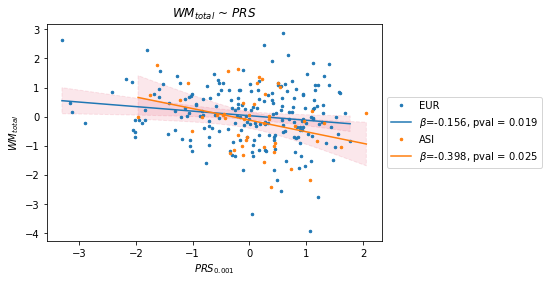

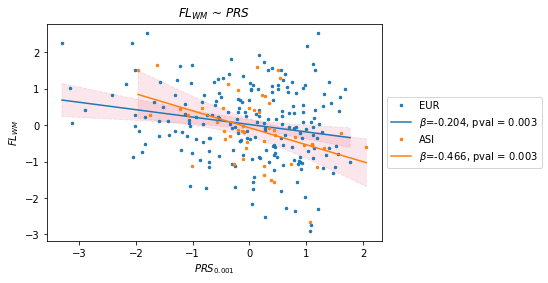

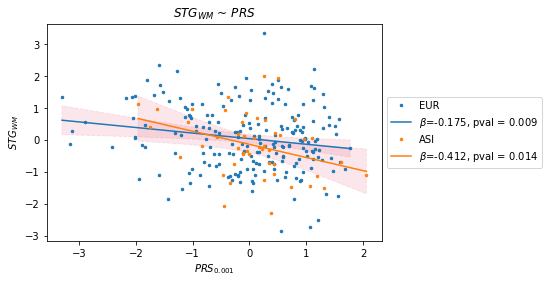

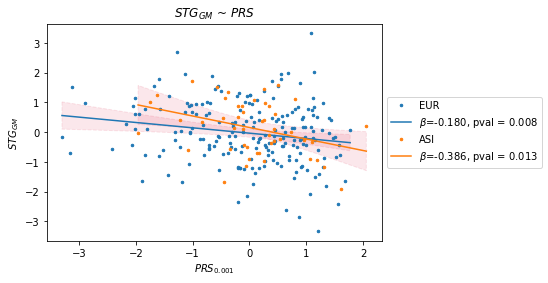

In [11]:
dependent_var = [
    'WM_sum_Imperial', 'Imperial 79', 'Imperial 58', 'Imperial 12'
]
ylbl = ['$WM_{total}$', '$FL_{WM}$', '$STG_{WM}$', '$STG_{GM}$']
ancestry = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
df = mixed_volumetric_dataset_term

for var, ylabel in (zip(dependent_var, ylbl)):
    model, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=[
            'GA_vol', 'PMA_vol', 'Intracranial_Imperial'
        ],
        dependentVar_cols=[var])
    model2, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cont_independentVar_cols=ancestry,
        dependentVar_cols=['PRS_0.001'])
#     plt.style.use('seaborn-whitegrid')
    visualisation.plot_Linear_Reg(
        model2.resid.values,
        model.resid.values,
        data=mixed_volumetric_dataset_term,
        ylabel=ylabel,
        xlabel='$PRS_{0.001}$',
        hue='cohort',
        title='%s ~ $PRS$' % ylabel,
        combined=False,
    markersize=5)

## Other tests

### check if removing or adding variables changes the R2

In [20]:
all_models = data_exploration.MassUnivariate.check_all_predictors_combo_linear_Reg(
    df=european_volumetric_dataset_term,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=[
        'PRS_0.05_SCZ_AllLD','GA_vol', 'PMA_vol', 'Intracranial_Imperial'
    ]+[f'euro_Anc_PC{i}' for i in range(1,10)],
    dependentVar_cols=['WM_sum_Imperial'])

100%|███████████████████████████████████████████| 14/14 [03:19<00:00, 14.28s/it]


In [21]:
model_score_summary, model_var_summary, model_beta_summary, model_p_summary = data_exploration.MassUnivariate.preprocess_forward_selection(all_models)

The best model is when including all the covariates, but with less it still achieves similar results

In [27]:
model_score_summary.sort_values(by='AIC',ascending=True)

,N_var,AIC,R2,R2_adj
481,4,4216.988131,0.874016,0.871521
1533,5,4217.091053,0.875165,0.872060
3480,6,4217.240318,0.876276,0.872565
3662,6,4217.354011,0.876208,0.872495
1471,5,4217.406429,0.874975,0.871865
...,...,...,...,...
12743,8,4651.487738,0.011152,-0.028802
12744,8,4651.490428,0.011139,-0.028815
12741,8,4651.950549,0.008938,-0.031104
12742,8,4652.380801,0.006876,-0.033250


In [ ]:
model_score_summary.to_csv('./model_score_summary.csv',header=True,index=False)
model_var_summary.to_csv('./model_var_summary.csv',header=True,index=False)
model_beta_summary.to_csv('./model_beta_summary.csv',header=True,index=False)
model_p_summary.to_csv('./model_p_summary.csv',header=True,index=False)

In [66]:
to_plot = model_score_summary.sort_values(by='AIC',ascending=True).groupby('N_var').head(1).drop([0,5])

In [95]:
to_plot = to_plot.sort_values(by='N_var')

In [100]:
to_plot.AIC.values

array([4247.25087888, 4220.50713327, 4216.98813074, 4217.09105308,
       4217.24031824, 4217.41896935, 4218.08262223, 4219.53929199,
       4221.35673051, 4223.23317625, 4225.18042835, 4227.1544818 ,
       4229.15320772])

Text(0, 0.5, '$R^2$')

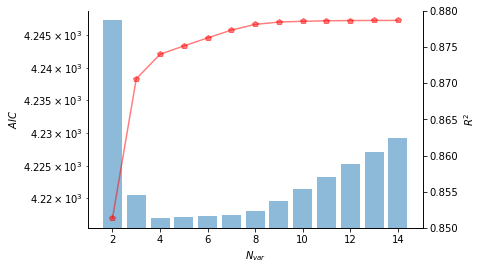

In [116]:
fig,ax = plt.subplots()
ax.bar(to_plot.N_var.values,to_plot.AIC.values,alpha=0.5)
ax.set_yscale('log')
ax2 = ax.twinx()
ax2.plot(to_plot.N_var.values,to_plot.R2.values,'rp-',alpha=0.5)
sns.despine(top=True,right=False)
ax.set_xlabel('$N_{var}$')
ax.set_ylabel('$AIC$')
ax2.set_ylabel('$R^2$')

(12627,) (12627,) 12627
(12627,) (12627,) 12627


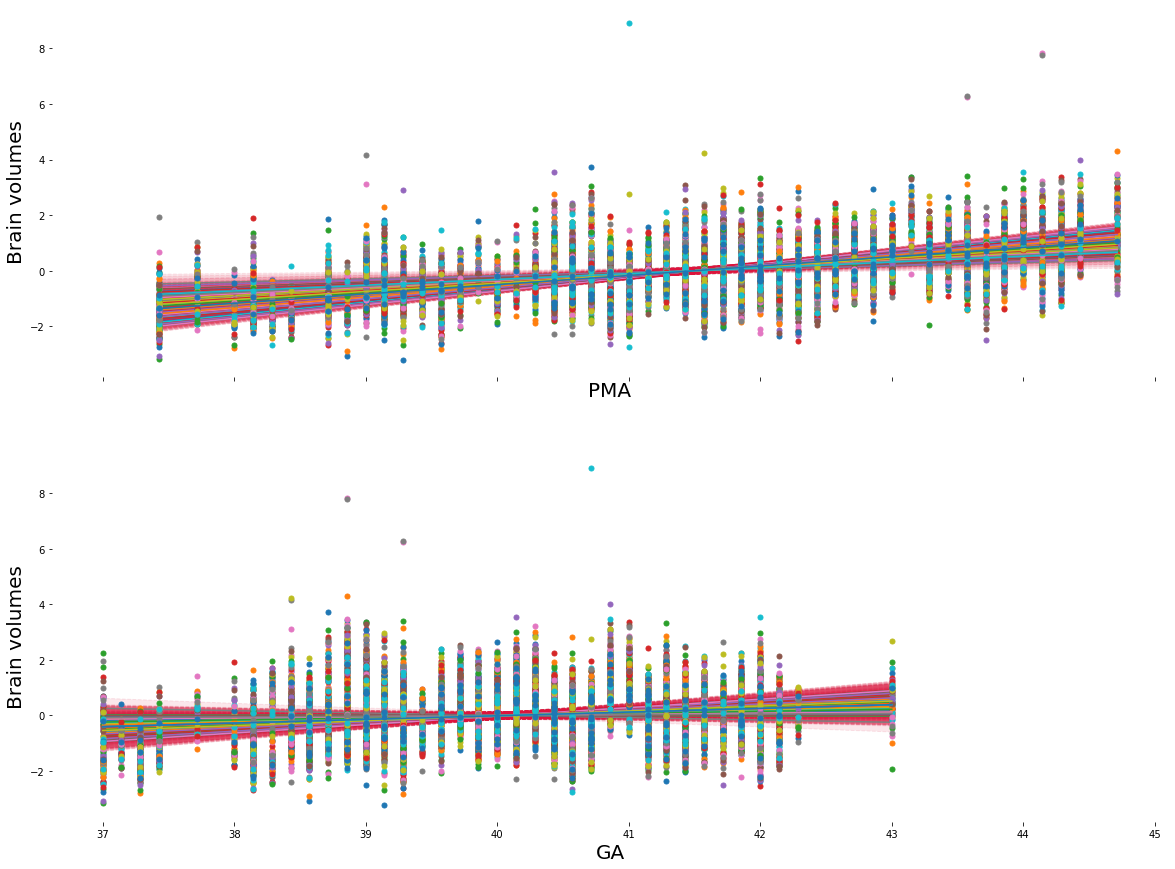

In [22]:
fig,axes = plt.subplots(2,1,sharex=True,figsize=(20,15))
visualisation.simple_plots.plot_Linear_Reg(x='PMA_vol',
                                          y = dependentVar,
                                          data = european_volumetric_dataset_term,
                                          ylabel = 'Brain volumes',
                                          xlabel = 'PMA',
                                          ax= axes[0],markersize=10,fontsize=20,legend=False,scaling='y')
visualisation.simple_plots.plot_Linear_Reg(x='GA_vol',
                                          y = dependentVar,
                                          data = european_volumetric_dataset_term,
                                          ylabel = 'Brain volumes',
                                          xlabel = 'GA',
                                          ax= axes[1],markersize=10,fontsize=20,legend=False,scaling='y')
sns.despine(bottom=True,left=True)
fig.savefig('./corr_with_brain.png',bbox_inches='tight')

In [47]:
european_volumetric_dataset_term[[i for i in european_volumetric_dataset_term.columns if 'Anc' in i]]

,euro_Anc_PC1,euro_Anc_PC2,euro_Anc_PC3,euro_Anc_PC4,euro_Anc_PC5,euro_Anc_PC6,euro_Anc_PC7,euro_Anc_PC8,euro_Anc_PC9,euro_Anc_PC10_x,...,euro_Anc_PC91,euro_Anc_PC92,euro_Anc_PC93,euro_Anc_PC94,euro_Anc_PC95,euro_Anc_PC96,euro_Anc_PC97,euro_Anc_PC98,euro_Anc_PC99,euro_Anc_PC100
0,0.039504,0.005096,0.011502,-0.015515,-0.040194,-0.047644,0.015489,0.016909,0.047587,0.035822,...,-0.003929,0.014023,0.044401,-0.025109,-0.042785,-0.042331,0.093802,-0.071342,-0.023462,-0.027251
1,-0.104926,0.017360,-0.081602,0.064676,0.014311,-0.124021,-0.030445,0.138273,0.025256,-0.151195,...,0.032481,-0.009867,-0.068027,0.077548,-0.037440,-0.104236,-0.091572,0.074344,0.057991,0.035292
2,-0.131693,-0.071335,-0.005028,-0.047907,-0.047771,0.051243,0.008518,-0.349793,0.003266,-0.185741,...,0.009134,0.062602,-0.047151,0.027545,-0.022549,-0.005937,-0.021042,-0.045526,-0.017756,-0.080407
3,0.038875,0.025852,-0.040086,-0.006392,0.040389,0.027799,0.010049,0.029825,-0.038966,-0.001814,...,0.022543,-0.009944,0.003428,-0.029350,0.018676,0.008933,-0.057236,-0.003561,-0.039680,0.000973
4,0.057020,-0.001994,-0.012540,0.008847,-0.007488,-0.000583,-0.001316,0.041099,-0.061148,0.001712,...,-0.010993,0.083900,-0.020740,-0.034941,0.043850,-0.057896,-0.036421,-0.020240,0.015281,0.017052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.017693,0.010404,0.060110,-0.021095,0.002916,-0.071615,0.002567,0.004443,0.029996,-0.025836,...,0.000291,0.003893,-0.032718,-0.019965,0.088877,0.043486,-0.052517,-0.007752,-0.035839,0.056583
203,0.049823,-0.018725,0.004178,0.035245,-0.000106,-0.000078,-0.022110,-0.026851,0.001260,-0.015119,...,-0.015402,0.037139,-0.061007,-0.048096,0.042280,-0.032886,0.020956,-0.024691,-0.119779,0.070455
204,0.039676,0.001762,0.035235,0.002525,-0.004817,0.047225,-0.004450,-0.008688,-0.010704,0.005674,...,0.049099,-0.070101,-0.058108,0.026929,-0.013871,0.002512,0.067396,0.025626,0.051314,-0.012712
205,0.007500,-0.036657,0.038748,0.054108,-0.016922,-0.031494,-0.018503,-0.007031,-0.022220,0.017264,...,-0.035545,-0.045964,-0.006335,-0.002677,0.058004,0.082734,0.031586,-0.044504,-0.046357,-0.019710


In [50]:
ancestry=[f'euro_Anc_PC{i}' for i in range(1,16)]
euro_all_models = data_exploration.MassUnivariate.check_all_predictors_combo_linear_Reg(european_volumetric_dataset_term,
                                                                     cat_independentVar_cols=['Gender'],
                                                                     cont_independentVar_cols=['GA_vol','PMA_vol',
                                                                                       'Intracranial_Imperial','PRS_0.05']+
                                                                     ancestry,
                                                                     dependentVar_cols=['Imperial 79'],
                                                                      check_plan='sequential',
                                                                                  check_cols=ancestry)
ancestry=[f'mixed_Anc_PC{i}' for i in range(1,31)]
mixed_all_models = data_exploration.MassUnivariate.check_all_predictors_combo_linear_Reg(mixed_volumetric_dataset_term,
                                                                     cat_independentVar_cols=['Gender'],
                                                                     cont_independentVar_cols=['GA_vol','PMA_vol',
                                                                                       'Intracranial_Imperial','PRS_0.001']+
                                                                     ancestry,
                                                                     dependentVar_cols=['Imperial 79'],
                                                                      check_plan='sequential',
                                                                                  check_cols=ancestry)

15it [00:00, 72.83it/s]
30it [00:00, 58.34it/s]


In [51]:
euro_model_score,_,_,euro_model_p = data_exploration.MassUnivariate.preprocess_forward_selection(euro_all_models)
mixed_model_score,_,_,mixed_model_p = data_exploration.MassUnivariate.preprocess_forward_selection(mixed_all_models)

In [52]:
euro_model_score['PRS_pval'] = euro_model_p['PRS_0.05']
euro_model_score['N_var']  = euro_model_score['N_var'] - 5
mixed_model_score['PRS_pval'] = mixed_model_p['PRS_0.001']
mixed_model_score['N_var']  = mixed_model_score['N_var'] - 5

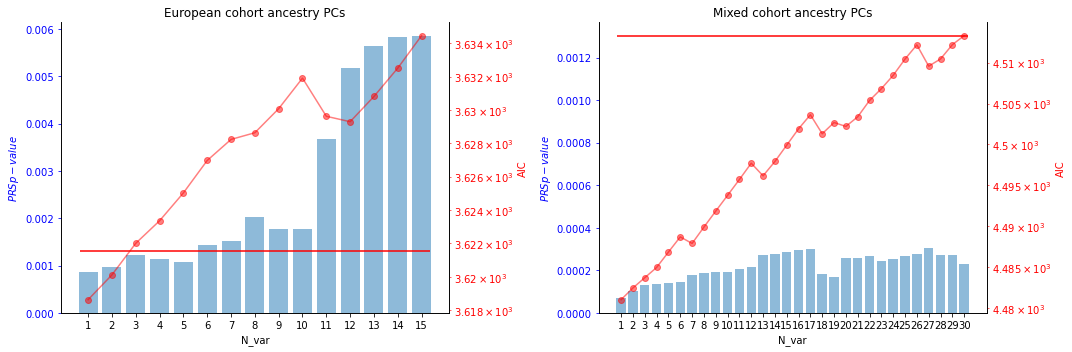

In [94]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes = axes.flatten()
data_euro = euro_model_score.drop(0)
visualisation.simple_plots.Bar(x='N_var',
                              y='PRS_pval',
                              data=data_euro,yscalelog=False,
                              order = {'x':[str(i) for i in range(1,16)]},alpha=0.5,hline=0.0013,
                              ax = axes[0])
axes[0].tick_params(which='both',axis='y',colors='b')
axes[0].set_ylabel('$PRS p-value$',color='b')
ax2 = axes[0].twinx()
ax2.plot(data_euro['N_var'],data_euro['AIC'],'or-',alpha=0.5)
ax2.set_yscale('log')
ax2.tick_params(which='both',axis='y',colors='r')
ax2.set_ylabel('AIC',color='r')
axes[0].set_title('European cohort ancestry PCs')

data_mixed = mixed_model_score.drop(0)

visualisation.simple_plots.Bar(x='N_var',
                              y='PRS_pval',
                              data=data_mixed,yscalelog=False,
                              order = {'x':[str(i) for i in range(1,31)]},alpha=0.5,hline=0.0013,
                              ax = axes[1])
ax2 = axes[1].twinx()
ax2.plot(data_mixed['N_var'],data_mixed['AIC'],'or-',alpha=0.5)
axes[1].tick_params(which='both',axis='y',colors='b')
axes[1].set_ylabel('$PRS p-value$',color='b')
ax2.set_yscale('log')
ax2.set_ylabel('AIC',color='r')
ax2.tick_params(which='both',axis='y',colors='r')
ax2.set_ylabel('AIC',color='r')
axes[1].set_title('Mixed cohort ancestry PCs')
sns.despine(top=True,right=False)
plt.tight_layout()
fig.savefig('./ancestry_PCs.png')

### adding preterm

In [29]:
european_volumetric_preterm_term_mass_univariate = pd.read_csv(
    './preprocessed_dataset/imaging_data/volumetric/preterm_term/european_volumetric_preterm_term_mass_univariate.csv'
)

In [32]:
data_preprocessing.Volumes.extract_WM_Imperial(european_volumetric_preterm_term_mass_univariate).sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
630,Imperial 79,0.089234,0.009166,0.222168,1.095722e-10,-0.598642,1.375070e-21,-0.036649,0.158641,-0.028282,0.262465,0.019237,0.433409,1.248126,4.956868e-67,-0.070116,0.005742,-0.197588,0.000222,PRS_0.1
558,Imperial 79,0.088570,0.009781,0.221963,1.188279e-10,-0.599497,1.328617e-21,-0.034744,0.180228,-0.028948,0.252092,0.019136,0.436547,1.249594,4.398070e-67,-0.067245,0.007844,-0.196119,0.000251,PRS_0.05
414,Imperial 79,0.086724,0.011485,0.222626,1.086336e-10,-0.605411,5.751416e-22,-0.031050,0.227522,-0.027863,0.270361,0.014314,0.558126,1.255667,1.133521e-67,-0.064906,0.009110,-0.192031,0.000343,PRS_0.001
270,Imperial 79,0.086523,0.011685,0.222842,1.049350e-10,-0.608548,3.778565e-22,-0.027886,0.275968,-0.026680,0.291166,0.011953,0.624339,1.259979,4.896486e-68,-0.064263,0.009188,-0.191586,0.000354,PRS_1e-05
280,WM_sum_Imperial,0.094424,0.000977,0.186887,7.194661e-11,-0.494796,1.970774e-21,-0.020011,0.346474,-0.022522,0.283408,0.005777,0.775667,1.222138,4.033948e-80,-0.052604,0.010241,-0.209081,0.000003,PRS_1e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,Imperial 55,-0.014055,0.814985,0.294812,7.870784e-07,-0.267992,8.047819e-03,0.062955,0.168771,0.029200,0.512209,0.001909,0.964887,0.784182,5.136692e-16,-0.001004,0.981913,0.031123,0.738435,PRS_0.05
339,Imperial 66,0.102358,0.041317,0.060628,2.105757e-01,-0.551098,2.278240e-10,0.000105,0.997776,-0.027987,0.449537,-0.024654,0.490684,1.202985,3.573970e-40,0.000623,0.986190,-0.226651,0.003773,PRS_0.0001
254,Imperial 51,0.075592,0.178395,0.035679,5.111853e-01,0.075170,4.215992e-01,-0.000051,0.999042,-0.022600,0.586387,-0.015904,0.691993,0.693568,7.734637e-15,0.000643,0.987273,-0.167383,0.055429,PRS_1e-05
38,Imperial 51,0.075549,0.178456,0.035702,5.108313e-01,0.075171,4.215911e-01,-0.000130,0.997530,-0.022595,0.586482,-0.015888,0.692314,0.693525,7.580347e-15,-0.000250,0.995037,-0.167286,0.055354,PRS_1e-08


# Release 3

In [6]:
european_volumetric_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [7]:
european_volumetric_term.drop_duplicates(subset='ID',keep='first')

,ID,Session,TBV,ICV,CSF,GM,WM,Background,Ventricles,Cerebellum,...,ASD_PRS_Pt_1e-07,ASD_PRS_Pt_1e-06,ASD_PRS_Pt_1e-05,ASD_PRS_Pt_0.0001,ASD_PRS_Pt_0.001,ASD_PRS_Pt_0.01,ASD_PRS_Pt_0.05,ASD_PRS_Pt_0.1,ASD_PRS_Pt_0.5,ASD_PRS_Pt_1
0,CC00749XX24,2600,422755.875,516267.250,89299.500,186431.125,159458.500,42253.500,4211.875,34543.375,...,-0.068172,0.001457,0.014132,-0.003923,-0.003222,-0.002080,-0.001829,-0.001661,-0.001067,-0.000823
1,CC00803XX11,2700,339311.375,426793.875,71507.125,142816.500,137087.375,41193.500,15975.375,24617.375,...,-0.064572,-0.009543,0.008322,-0.005172,-0.002964,-0.002129,-0.001704,-0.001572,-0.001032,-0.000796
2,CC00818XX18,4020,409979.000,495277.375,79400.250,177465.500,163106.125,45333.125,5898.125,30145.000,...,-0.064572,-0.008943,0.003355,-0.008006,-0.003966,-0.002065,-0.001901,-0.001642,-0.001035,-0.000806
3,CC00815XX15,4120,379317.875,454117.125,71501.750,160427.250,156481.750,45103.750,3297.500,25969.125,...,-0.068172,-0.006516,0.009228,-0.006991,-0.002948,-0.002005,-0.001714,-0.001585,-0.001056,-0.000812
4,CC00766XX16,4200,358265.000,441757.625,79461.375,157570.500,137294.250,41553.750,4031.250,27287.250,...,-0.064572,-0.000971,0.005120,-0.006163,-0.003076,-0.002360,-0.001868,-0.001740,-0.001086,-0.000833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,CC00685XX18,226100,425322.625,535228.625,101917.500,190254.125,163305.750,44798.375,7988.500,30173.250,...,-0.088497,-0.006987,0.000992,-0.009806,-0.004350,-0.002211,-0.001744,-0.001626,-0.001078,-0.000831
289,CC00713XX12,229000,434705.625,550515.125,107302.625,183386.125,176498.625,49443.375,8506.875,31518.125,...,-0.088497,-0.003287,0.007648,-0.006845,-0.002441,-0.001915,-0.001654,-0.001570,-0.001054,-0.000817
290,CC00740XX15,238400,406146.000,506014.125,92708.375,172988.125,161010.125,47751.000,7159.750,30949.750,...,-0.047848,-0.002338,0.005636,-0.006541,-0.002602,-0.001650,-0.001549,-0.001526,-0.001029,-0.000791
291,CC00777XX19,239102,419587.375,503957.375,79029.875,174203.500,173343.875,45315.125,5340.125,29430.625,...,-0.044248,0.003317,0.013454,-0.003949,-0.002660,-0.002106,-0.001630,-0.001541,-0.001042,-0.000804


In [8]:
ancestry=[f'euro_Anc_PC{i}' for i in range(1,4)]
df = european_volumetric_term.copy()
df = stats.MassUnivariate.remove_outliers(df,col=ancestry,threshold=3.5)

In [9]:
df.shape

(286, 191)

In [10]:
candidate_genes=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/genetic_dataset/target_files/genotyped.raw')

In [11]:
candidate_genes = candidate_genes[['ID','2:185778428_C']].copy()

In [12]:
candidate_genes.columns = ['ID','ZNF804A']

In [13]:
df=df.merge(candidate_genes,on=['ID'])

In [14]:
df['WM_total'] = data_preprocessing.Volumes.Imperial.get_segment(df,tissue=['WM']).sum(axis=1)
df['GM_total'] = data_preprocessing.Volumes.Imperial.get_segment(df,tissue=['GM']).sum(axis=1)
# df = stats.MassUnivariate.remove_outliers(df,col=['WM_total','GM_total','TBV'],threshold=3.5)

In [15]:
df[['WM_total_adj','GM_total_adj','TBV_adj']] = stats.MassUnivariate.adjust_covariates_with_lin_reg(df,cat_independentVar_cols=['sex'],
                                                    cont_independentVar_cols=['GA','PMA','TBV','ZNF804A']+ancestry,
                                                    dependentVar_cols=['WM_total','GM_total','TBV']).copy()

In [16]:
df = stats.MassUnivariate.remove_outliers(df,col=['WM_total_adj','GM_total_adj'],threshold=3.5)

In [17]:
df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['segmented'],drop_duplicates=True)

In [18]:
# european_volumetric_mass_univariate = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
#     df,
#     thresholds=PRS_columns,
#     cat_independentVar_cols=['sex'],
#     cont_independentVar_cols=['PMA','GA','ICV']+ancestry,
#     dependentVar_cols=[i for i in df.columns if 'Imperial' in i])

In [19]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(df,
                                     cat_independentVar_cols=['sex'],
                                    cont_independentVar_cols=['GA','PMA','TBV','ZNF804A']+ancestry,
                                    dependentVar_cols=[i for i in df.columns if 'Imperial' in i],return_ancova=True)

In [20]:
df['ZNF804A_status']=['carrier' if i<2 else 'non-carrier' for i in df['ZNF804A']]

In [22]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(df,
                                     cat_independentVar_cols=['sex'],
                                    cont_independentVar_cols=['GA','PMA','TBV','ZNF804A']+ancestry,
                                                          formula = 'GA+PMA+TBV+C(ZNF804A):C(sex)',
                                    dependentVar_cols=[i for i in df.columns if 'Imperial' in i],return_ancova=True)

In [22]:
def a(b):
    if b>1:
        return 'hi'

In [29]:
a(1) is None

True

In [24]:
mass_univariate.sort_values(by='C(ZNF804A):C(sex)_(PR>F)')

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,C(ZNF804A)[T.1]:C(sex)[female]_coef,C(ZNF804A)[T.1]:C(sex)[female]_pval,C(ZNF804A)[T.2]:C(sex)[female]_coef,C(ZNF804A)[T.2]:C(sex)[female]_pval,C(ZNF804A)[T.1]:C(sex)[male]_coef,C(ZNF804A)[T.1]:C(sex)[male]_pval,...,TBV_coef,TBV_pval,C(ZNF804A):C(sex)_F,C(ZNF804A):C(sex)_(PR>F),GA_F,GA_(PR>F),PMA_F,PMA_(PR>F),TBV_F,TBV_(PR>F)
Imperial 79,41220.285130,9.035100e-41,138.316022,0.594486,23.142213,0.922337,57.083691,0.846341,289.681082,0.195962,...,0.087398,3.360600e-104,67.879766,4.467085e-46,6.960922,8.803936e-03,523.932340,9.914395e-66,1242.705070,3.360600e-104
Imperial 80,41518.439851,5.134863e-42,141.910365,0.579579,165.140206,0.480598,268.684813,0.355210,305.710690,0.166371,...,0.086778,6.718586e-105,65.376249,7.425258e-45,5.685112,1.778520e-02,557.322976,3.474443e-68,1260.510941,6.718586e-105
Imperial 36,-24070.418646,1.116964e-24,-251.347147,0.237716,207.085500,0.286987,-138.707205,0.565184,332.153319,0.070463,...,0.079716,4.982945e-115,51.373931,1.561260e-37,736.857154,6.751389e-80,3349.140388,2.273977e-156,1543.230571,4.982945e-115
Imperial 82,19902.908808,2.264985e-20,180.001986,0.365189,-243.054890,0.181283,-349.297636,0.121773,-14.792550,0.931082,...,0.046168,1.054760e-70,42.437221,2.376838e-32,11.036660,1.013805e-03,333.186058,2.295083e-49,593.013331,1.054760e-70
Imperial 37,-24244.592611,3.514013e-26,-82.504631,0.688997,395.582530,0.036458,103.823616,0.656958,85.115790,0.631613,...,0.078287,2.411054e-116,42.406211,2.481833e-32,757.863791,3.957998e-81,3687.706664,1.009470e-161,1583.570775,2.411054e-116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Imperial 55,1177.601381,2.860870e-05,-18.789656,0.497519,-8.172856,0.746693,11.025051,0.725485,-11.042709,0.643281,...,0.002999,9.404889e-25,2.234398,5.116231e-02,5.186888,2.352298e-02,64.873485,2.412864e-14,128.795835,9.404889e-25
Imperial 18,-17990.506657,2.640641e-18,83.791928,0.662628,-30.659478,0.861305,270.454978,0.214858,-293.435517,0.076794,...,0.024703,3.708360e-32,2.229337,5.164740e-02,236.657736,5.450025e-39,1056.483661,2.361548e-96,181.665584,3.708360e-32
Imperial 52,157.249175,6.615933e-01,-35.354276,0.325188,9.488251,0.772453,66.848308,0.101432,44.449719,0.151262,...,0.003305,3.690219e-19,2.198311,5.471783e-02,13.886159,2.355685e-04,171.264674,9.007348e-31,93.028072,3.690219e-19
Imperial 49,1240.381896,6.507865e-01,62.671138,0.818988,-309.183315,0.217281,-420.548147,0.176360,-242.109818,0.305002,...,0.009897,1.874574e-04,2.123269,6.287634e-02,0.408936,5.230402e-01,37.870181,2.651784e-09,14.338011,1.874574e-04


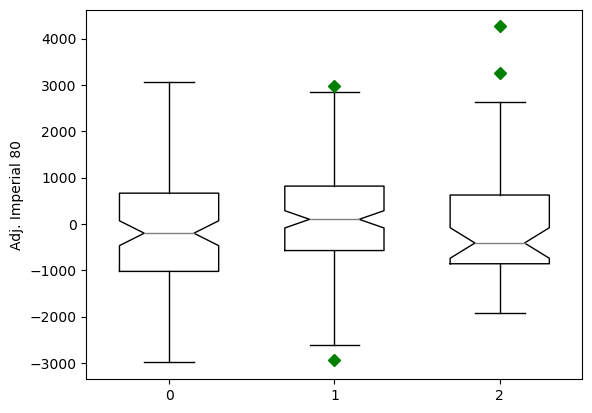

In [53]:
visualisation.SimplePlots.Box(x=['ZNF804A'],y=['Imperial 80'],data=df,adjust_covar={'y':['GA','PMA','TBV']},order=['0','1','2'],notch=True)

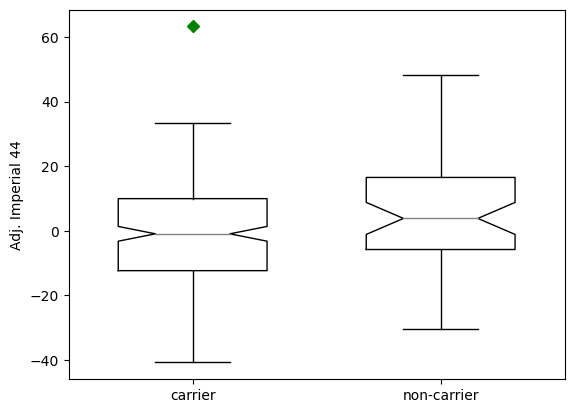

In [60]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [62]:
test = pairwise_tukeyhsd(df['Imperial 12'],groups=df['ZNF804A'])

In [65]:
test.pvalues

array([0.85230959, 0.56490668, 0.79734473])

In [41]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends()['Imperial 80']

{'name': 'Frontal lobe left WM',
 'tissue': 'WM',
 'lobe': 'frontal',
 'side': 'left',
 'segment': None,
 'structure': 'Frontal lobe',
 'abbr': 'FL.WM.left'}

In [34]:
mass_univariate.sort_values(by='standardize(ZNF804A)_(PR>F) ')

KeyError: 'ZNF804A_status_(PR>F)'

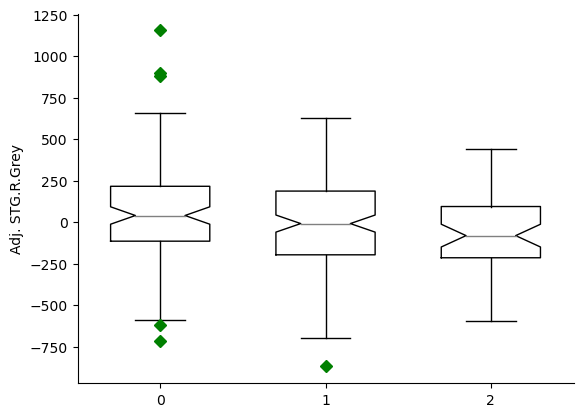

In [28]:
visualisation.SimplePlots.Box(x=['ZNF804A'],
                              y=['Imperial 12'],
                              adjust_covar={'y':['sex','GA','PMA','TBV']+ancestry},
                              data=df,order=['0','1','2'],notch=True,ylabel='STG.R.Grey')
sns.despine()

In [ ]:
from 

In [25]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends()['Imperial 20']

{'name': 'Insula right GM',
 'tissue': 'GM',
 'lobe': None,
 'side': 'right',
 'segment': None,
 'structure': 'Insula',
 'abbr': 'INSU.GM.right'}

In [24]:
stats.matSpDLite(np.corrcoef(df[[i for i in df.columns if 'Imperial' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 35.26617210638366
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 21.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0023809523809523803


21.000000000000007

<AxesSubplot:xlabel='ZNF804A', ylabel='Adj. Superior Temporal Gyrus Right'>

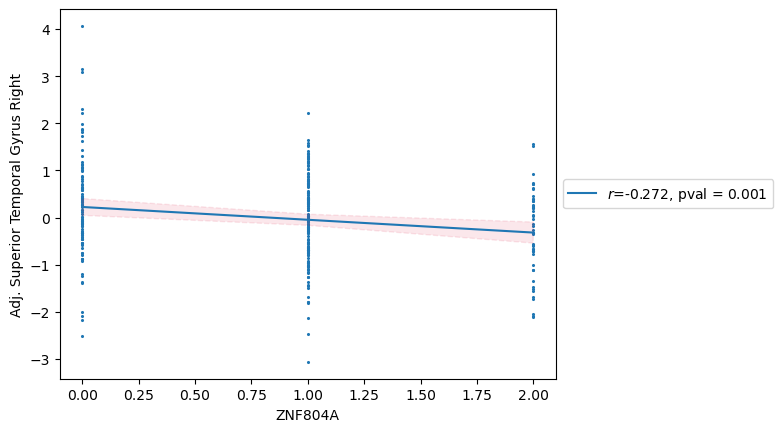

In [210]:
visualisation.SimplePlots.Scatter(x='ZNF804A',
                                 y='Imperial 12',data=df,adjust_covar={'y':['sex','PMA','GA','TBV']+ancestry},scaling='y',
                                 ylabel='Superior Temporal Gyrus Right')

In [215]:
df['STG_adj'] = stats.MassUnivariate.adjust_covariates_with_lin_reg(df,
                                                   cat_independentVar_cols=['sex'],
                                                   cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
                                                   dependentVar_cols=['Imperial 12'])

In [217]:
stats.matSpDLite(np.corrcoef(data_preprocessing.Volumes.Imperial.get_segment(df,tissue=['WM','GM','DGM']),rowvar=False))

Effective Number of Independent Variables [Veff] is 29.269126694758885
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 17.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0029411764705882366


16.999999999999993

In [138]:
mass_univariate = data_preprocessing.Volumes.Imperial.get_segment(mass_univariate,col='index',tissue=['WM','GM'])

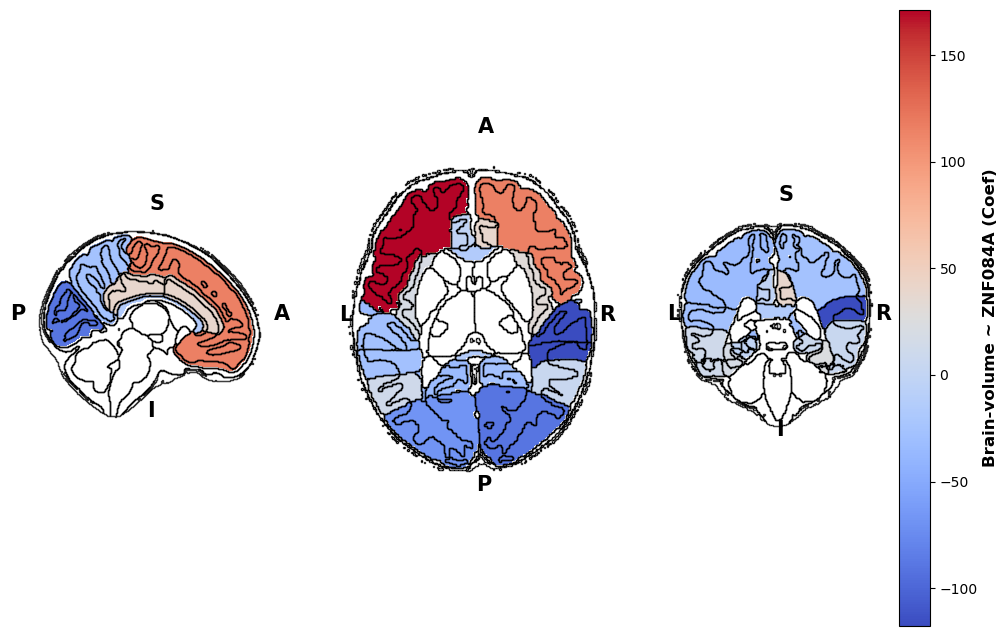

In [146]:
plot_labels = [int(i.replace('Imperial ','')) for i in mass_univariate.index]

prs_plot_value_values = mass_univariate.ZNF804A_coef.values
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 

fig,ax = plt.subplots(1,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap='coolwarm',
    cmap_reversed=False,
    axes=ax,
    fig=fig,
    cb_title='Brain-volume ~ ZNF084A (Coef)')


In [68]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends()['Imperial 12']

{'name': 'Superior temporal gyrus, middle part right GM',
 'tissue': 'GM',
 'lobe': 'temporal',
 'side': 'right',
 'segment': 'middle',
 'structure': 'Superior temporal gyrus',
 'abbr': 'STG.GM.right.middle'}

In [15]:
df.shape

(286, 265)

In [19]:
data_preprocessing.Volumes.Imperial.get_segment(european_volumetric_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(1),tissue=['WM'],col='Connection')

,Connection,const_coef,const_pval,PMA_coef,PMA_pval,GA_coef,GA_pval,ICV_coef,ICV_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,sex_male_coef,sex_male_pval,threshold
3836,Imperial 79,29866.229820,1.631971e-313,-1519.296018,2.499088e-16,-9.555106,0.934377,3978.787322,2.141483e-77,49.231827,0.596854,-72.412636,0.430094,76.314883,0.408174,-290.217844,0.001738,741.296053,0.000202,new_SCZ_Pt_Pt_0.001
3837,Imperial 80,30017.798747,2.975066e-319,-1470.836190,1.318364e-16,-98.238332,0.377217,3990.322942,2.174654e-81,-34.201758,0.701270,-109.126282,0.214912,59.773461,0.498806,-237.031886,0.007445,586.145793,0.002074,new_SCZ_Pt_Pt_0.001
5589,Imperial 51,1289.395749,2.174611e-191,46.907777,2.785658e-02,-48.552023,0.000656,140.130265,5.194633e-13,2.760387,0.809059,-16.353663,0.145467,-21.049888,0.061122,21.346924,0.061772,30.821875,0.198001,new_SCZ_Pt_Pt_0.23
5228,Imperial 58,4080.911361,9.473432e-238,-95.961981,3.449355e-02,-59.075311,0.049680,425.395994,5.230428e-23,-3.728833,0.878077,-9.320239,0.695250,23.218223,0.330386,-45.044297,0.063660,114.301704,0.025287,new_SCZ_Pt_Pt_0.074
2540,Imperial 52,1231.194577,2.339279e-193,25.980180,1.910157e-01,-16.975492,0.199872,151.636090,1.369063e-16,-7.652996,0.469346,6.349185,0.543096,-18.676715,0.076642,-18.873674,0.070431,-15.073293,0.502167,new_SCZ_Pt_Pt_2.1e-05
5293,Imperial 62,1912.236015,2.381046e-212,-23.218406,3.778249e-01,2.091751,0.904598,205.560731,3.989111e-17,19.035144,0.179981,-2.804444,0.839677,8.609226,0.534890,-21.524929,0.128517,109.036563,0.000272,new_SCZ_Pt_Pt_0.089
3462,Imperial 61,1908.166041,7.058961e-223,-11.460118,6.314900e-01,-24.747155,0.120546,211.762697,5.096914e-21,-3.042173,0.811014,1.961176,0.876065,11.455389,0.365590,-15.683434,0.212664,55.144641,0.041896,new_SCZ_Pt_Pt_0.00034
4198,Imperial 65,7033.295221,4.199695e-227,-213.493613,1.258605e-02,-81.200194,0.151951,986.116644,8.989365e-32,36.986419,0.416875,2.553317,0.954525,37.255424,0.407369,55.331901,0.221534,419.778513,0.000017,new_SCZ_Pt_Pt_0.0031
6080,Imperial 56,1143.570190,2.037638e-219,-11.039437,4.555090e-01,10.469457,0.287263,103.123499,3.142568e-14,2.696215,0.735403,3.712940,0.634483,-7.900176,0.312100,-9.682699,0.223298,30.982488,0.063742,new_SCZ_Pt_Pt_1
4750,Imperial 76,2713.714397,8.705954e-236,-87.776576,4.260273e-03,18.572432,0.359673,340.342492,5.512109e-30,18.126038,0.267577,14.295979,0.372171,-4.005606,0.803495,-19.321011,0.234173,13.536955,0.694169,new_SCZ_Pt_Pt_0.017


In [382]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends()['Imperial 80']

{'name': 'Frontal lobe left WM',
 'tissue': 'WM',
 'lobe': 'frontal',
 'side': 'left',
 'segment': None,
 'structure': 'Frontal lobe',
 'abbr': 'FL.WM.left'}

In [340]:
PRS_columns = [i for i in df.columns if 'new_SCZ' in i]

In [341]:
prs_pca_model,PRS_pca,loading_matrix = stats.FeatureReduction.perform_PCA(df,dependentVar_cols=PRS_columns,scaling=True)

In [342]:
df['PRS_pca'] = PRS_pca[:,0]

In [343]:
_, pca_mass_univariate = stats.MassUnivariate.mass_univariate(df,
                                    cat_independentVar_cols=['sex'],
                                    cont_independentVar_cols=['GA','PMA','ICV','PRS_pca']+ancestry,
                                    dependentVar_cols=[i for i in df.columns if 'Imperial' in i])

In [350]:
data_preprocessing.Volumes.Imperial.get_segment(pca_mass_univariate,tissue=['WM'],col='index').sort_values(by='PRS_pca_pval')

,const_coef,const_pval,GA_coef,GA_pval,PMA_coef,PMA_pval,ICV_coef,ICV_pval,PRS_pca_coef,PRS_pca_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,sex_male_coef,sex_male_pval
Imperial 79,29858.756648,4.343221e-313,-3.621133,0.975190,-1524.819624,2.558865e-16,3978.854208,5.243571e-77,258.182557,0.005463,50.819282,0.586927,-76.030890,0.409189,74.878938,0.418770,755.835693,0.000159
Imperial 80,30011.540782,6.610104e-319,-93.257680,0.403134,-1476.241897,1.297161e-16,3990.981989,4.666627e-81,206.595110,0.019966,-32.339479,0.717977,-112.546773,0.202325,58.530150,0.509086,598.321153,0.001718
Imperial 52,1230.810211,3.930002e-193,-17.151269,0.196222,25.886861,1.942293e-01,151.283637,1.996513e-16,15.653889,0.136850,-8.035241,0.450469,6.359582,0.544005,-19.135518,0.070090,-14.325480,0.524185
Imperial 62,1912.558123,4.324593e-212,2.439860,0.889033,-25.625354,3.298325e-01,208.147546,1.449625e-17,14.827414,0.285149,21.337579,0.129473,-4.255736,0.758258,8.900661,0.522099,108.409875,0.000305
Imperial 58,4080.792531,3.361820e-237,-58.009759,0.054926,-102.462872,2.422805e-02,431.854922,1.367487e-23,23.658726,0.322081,1.588411,0.947649,-12.732337,0.593030,23.486755,0.327044,114.532898,0.025690
Imperial 65,7035.274740,4.360857e-227,-83.086535,0.142812,-209.483835,1.427397e-02,982.917887,1.218181e-31,-42.633195,0.342195,34.235390,0.451520,4.700488,0.916337,37.700747,0.402257,415.927203,0.000020
Imperial 76,2712.854021,9.764138e-236,18.983866,0.349474,-89.205373,3.661932e-03,341.819260,2.938025e-30,14.776253,0.358143,19.237759,0.238016,13.895995,0.386364,-3.801700,0.813521,15.210883,0.658429
Imperial 51,1288.937465,1.073928e-190,-49.176969,0.000597,50.427677,1.847343e-02,136.468335,1.771502e-12,-8.047111,0.473952,-0.140450,0.990156,-14.012110,0.211832,-21.465643,0.057553,31.713502,0.187963
Imperial 55,1180.180094,1.434600e-214,1.955078,0.853171,-33.711351,3.440474e-02,124.263168,3.100912e-17,5.853708,0.484610,6.230660,0.462921,5.386373,0.519166,-4.414061,0.599200,-6.236443,0.727914
Imperial 82,17403.301662,7.378574e-291,-55.414747,0.498004,-590.435319,2.465235e-06,2092.379443,2.140649e-54,45.205227,0.485501,-56.537428,0.389458,41.270316,0.523290,-29.630984,0.648435,619.150331,0.000012


<AxesSubplot:xlabel='new_SCZ_Pt_Pt_0.001', ylabel='PRS_pca'>

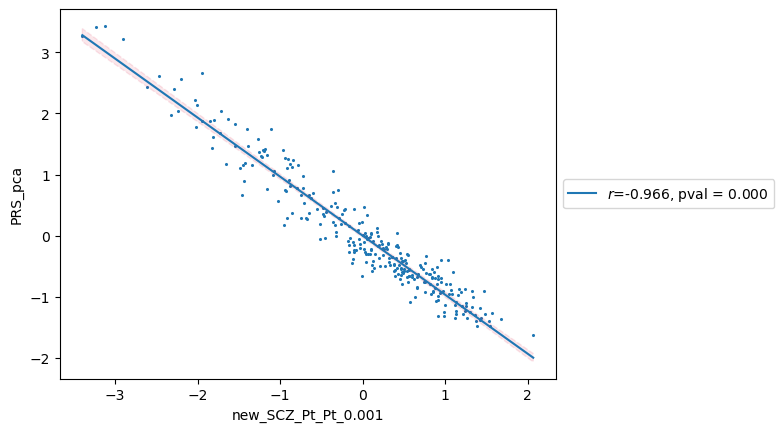

In [347]:
visualisation.SimplePlots.Scatter(x='new_SCZ_Pt_Pt_0.001',y='PRS_pca',data=df)

<AxesSubplot:>

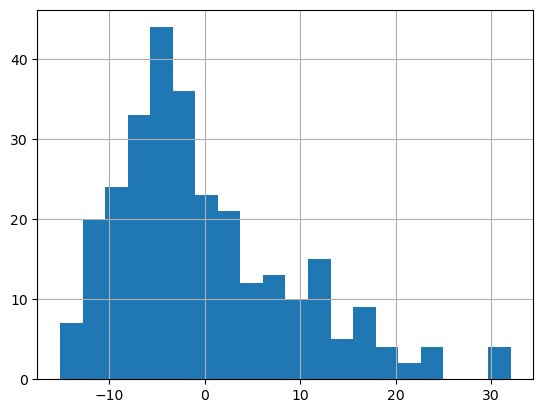

In [349]:
df['PRS_pca'].hist(bins=20)

<AxesSubplot:xlabel='Imperial 79', ylabel='PRS_pca'>

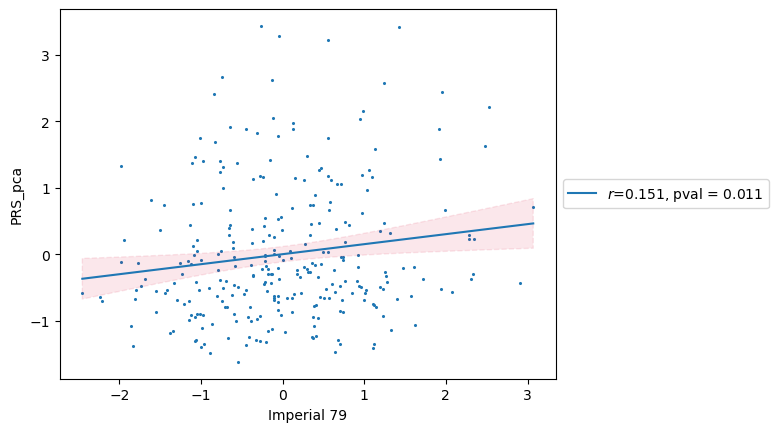

In [345]:
visualisation.SimplePlots.Scatter(x='Imperial 79',y='PRS_pca',data=df)

In [22]:
stats.matSpDLite(np.corrcoef(data_preprocessing.Volumes.Imperial.get_segment(df,tissue=['WM','GM']),rowvar=False))

Effective Number of Independent Variables [Veff] is 21.912734855553126
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 13.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0038461538461538494


12.99999999999999

In [26]:
from sklearn.datasets import load_iris

# Load the dataset
iris = load_iris()

In [27]:
import pandas as pd

# Extract the data
data = pd.DataFrame(iris['data'], columns=iris['feature_names'])
# Extract the target
target = pd.DataFrame(iris['target'], columns=['species'])
# Translate the target
class2species = dict(enumerate(iris['target_names']))
target['species'] = target['species'].replace(class2species)
# Combine into one dataset
df = pd.concat([target, data], axis='columns')


{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [237]:
import matplotlib.pyplot as plt

ax = plt.axes()
bp = ax.boxplot(data, widths=0.6, patch_artist=True)

plt.show()

,const,sex,bmi
0,1.0,0.050680,0.061696
1,1.0,-0.044642,-0.051474
2,1.0,0.050680,0.044451
3,1.0,-0.044642,-0.011595
4,1.0,-0.044642,-0.036385
...,...,...,...
437,1.0,0.050680,0.019662
438,1.0,0.050680,-0.015906
439,1.0,0.050680,-0.015906
440,1.0,-0.044642,0.039062


# Batch 2 genetics by Hai

## performing only with EUR cohort

In [263]:
full_dataset = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/combined_imaging_full_dataset_release3.csv')
print(full_dataset.shape)
full_dataset = full_dataset.sort_values(by='Session').drop_duplicates(subset=['ID'],keep='first')
print(full_dataset.shape)
full_dataset = full_dataset[(full_dataset['GA']>=37) & (full_dataset['PMA']>=37) & (~full_dataset['Imperial 1'].isna())]
print(full_dataset.shape)
full_dataset = full_dataset[(full_dataset['radiology_score']<5) & (full_dataset['radiology_low_image_quality']==False)]
print(full_dataset.shape)

(887, 138)
(783, 138)
(577, 138)
(552, 138)


In [264]:
# cohort_outputs = ['EUR', 'EUR_SAS', 'EUR_SAS_EAS', 'EUR_EAS', 'EUR_SAS_EAS_AMR', 'EUR_EAS_SAS_AMR_AFR', 'FULL'] # 7
# lds =  ['EUR', 'EUR_EAS', 'EUR_EAS_SAS', 'EUR_SAS', 'EUR_EAS_SAS_AMR', 'FULL']
# summary_stats = ['core', 'primary', 'european']

In [298]:
import os
cohort_outputs = ['EUR_SAS'] # 7
lds =  ['EUR', 'EUR_EAS', 'EUR_EAS_SAS', 'EUR_SAS', 'EUR_EAS_SAS_AMR', 'FULL']
summary_stats = ['core', 'primary', 'european','asian']
root='batch2_%s_genotyped.50'%cohort_outputs[0]
Anc_PCs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files(
    '../../dataset/preprocessed_dataset/batch2_HAI/%s/%s.pca.eigenvec'%(cohort_outputs[0],root),
                                                                        column_prefix='euro_Anc_')
SCZ_prs=pd.DataFrame()
for cohort_output in cohort_outputs:
    for ld in lds:
        for summary_stat in summary_stats:
            temp1 = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files(
                '../../dataset/preprocessed_dataset/batch2_HAI/%s/PRS/PRSice/batch2_%s_genotyped.50.SCZ.%s.ld_%s.all_score'%(cohort_output,cohort_output,summary_stat,ld),
                column_prefix='SCZ_PRS_',
                column_suffix='_LD_%s_stat_%s'%(ld,summary_stat))
            temp1 = temp1.set_index('ID')
            SCZ_prs = pd.concat([SCZ_prs,temp1],axis=1)
            if os.path.isfile('../../dataset/preprocessed_dataset/batch2_HAI/%s/PRS/PRScs/batch2_%s_genotyped.50.SCZ.%s.PRScs.profile'%(cohort_output,cohort_output,summary_stat)):
                
                temp2 = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files(
                    '../../dataset/preprocessed_dataset/batch2_HAI/%s/PRS/PRScs/batch2_%s_genotyped.50.SCZ.%s.PRScs.profile'%(cohort_output,cohort_output,summary_stat),
                    column_prefix='SCZ_PRS_',
                    column_suffix='_PRScs_stat_%s'%(summary_stat))
                temp2 = temp2.set_index('ID')
                SCZ_prs = pd.concat([SCZ_prs,temp2[['SCZ_PRS_SCORESUM_PRScs_stat_%s'%(summary_stat)]]],axis=1)
SCZ_prs = SCZ_prs.reset_index()
SCZ_prs = SCZ_prs.loc[:,~SCZ_prs.columns.duplicated()].copy()

In [299]:
print(SCZ_prs.shape)
european_volumetric_term = pd.merge(SCZ_prs,Anc_PCs,on='ID').merge(full_dataset,on='ID')
print(european_volumetric_term.shape)

(489, 244)
(323, 391)


In [300]:
ancestry=[f'euro_Anc_PC{i}' for i in range(1,6)]
df = european_volumetric_term.copy()
df['GM_proportion'] = df['GM']/df['TBV']
df['WM_proportion'] = df['WM']/df['TBV']
print(df.shape)
df = stats.MassUnivariate.remove_outliers(df,col=['GM_proportion','WM_proportion'],threshold=3,
                                                   remove_schemes='any')
print(df.shape)
df = stats.MassUnivariate.remove_outliers(df,col=ancestry,remove_schemes='any',threshold=4)
print(df.shape)

(323, 393)
(321, 393)
(317, 393)


In [301]:
df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping='segmented')

In [269]:
df_euro = pd.read_csv('eur_cohort_segmented_scz_prs_all.csv')
df_mixed = pd.read_csv('mixed_cohort_segmented_scz_prs_all.csv')

In [302]:
# birthweight = df[['ID','sex','GA','birth_weight']].copy()
# birthweight['GA'] = birthweight['GA'].apply(lambda x: int(x*7))
# birthweight.columns = ['ID','Sex','GA','Weight']
# birthweight.to_csv('mixed_bw.csv',header=True,index=False)
birthweight = pd.read_csv('mixed_bw_zscore.csv')[['Id','WeightZScore']].dropna()
df = df.merge(birthweight,left_on='ID',right_on='Id')

In [210]:
ancestry = [f'euro_Anc_PC{i}' for i in range(1,4)]
euro_result = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df_euro,
    thresholds=[i for i in df.columns if 'SCZ_PRS' in i and 'core' in i and 'LD_EUR_stat' in i or ('PRScs' in i and 'core' in i)],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in df.columns if 'Imperial' in i] + ['WM','GM']
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.30s/it]


In [211]:
stats.MultipleCorrection.matSpDLite(np.corrcoef(data_preprocessing.Volumes.Imperial.get_segment(df,tissue=['WM','GM']),rowvar=False))
stats.MultipleCorrection.matSpDLite(np.corrcoef(df[[i for i in df.columns if 'SCZ_PRS' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 22.176309717136395
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 13.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0038461538461538446
Effective Number of Independent Variables [Veff] is 152.346951765692
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 28.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0017857142857142841


28.000000000000025

In [ ]:
# visualisation.SimplePlots.Scatter(x='Imperial 79',
#                                  y='SCZ_PRS_Pt_0.001_LD_EUR_stat_european',
#                                  data=df,adjust_covar={'x':['TBV','GA','PMA','sex'],
#                                                       'y':ancestry})

In [212]:
euro_result_only_WM_GM = data_preprocessing.Volumes.Imperial.get_segment(euro_result,tissue=['WM','GM'],col='Connection')
euro_result_only_WM_GM = pd.concat([euro_result_only_WM_GM,euro_result[euro_result['Connection'].isin(['WM','GM'])]])
# euro_result_only_WM_GM.to_csv('SCZ_cohort_EUR_ld_EUR_stat_CORE_WM_GM_only.csv',index=False)

In [213]:
euro_result_only_WM_GM.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
306,Imperial 79,30006.795082,0.000000e+00,248.777652,0.120852,22.095197,0.806733,-1668.329866,4.463043e-28,4141.117034,1.002529e-100,5.786090,0.937072,77.073635,0.285442,-102.509911,0.153815,-251.936626,0.000660,SCZ_PRS_Pt_0.001_LD_EUR_stat_core
369,Imperial 79,30000.916120,0.000000e+00,260.407772,0.106238,28.039970,0.757426,-1670.966578,7.636972e-28,4131.924326,1.194369e-99,0.834304,0.990976,82.246254,0.256853,-93.803283,0.193780,-218.380420,0.003358,SCZ_PRS_Pt_0.01_LD_EUR_stat_core
684,Imperial 79,29998.117337,0.000000e+00,265.944495,0.098940,20.576701,0.820896,-1674.980873,5.390164e-28,4137.447874,6.335455e-100,-4.089744,0.955621,78.829500,0.278094,-94.422478,0.190897,-216.766377,0.003382,SCZ_PRS_SCORESUM_PRScs_stat_core
180,Imperial 79,30005.144224,0.000000e+00,252.043478,0.118804,38.082331,0.675268,-1691.493979,1.670859e-28,4155.289832,1.636522e-100,-17.127211,0.814724,87.484970,0.227596,-102.821058,0.155838,-203.979663,0.005330,SCZ_PRS_Pt_1e-05_LD_EUR_stat_core
466,Imperial 38,19256.138793,3.458460e-322,-243.450303,0.025545,105.778085,0.085233,803.792405,1.834085e-16,2451.708893,5.841243e-88,-50.198408,0.320346,-35.771539,0.469991,43.837384,0.367958,141.160791,0.005799,SCZ_PRS_Pt_0.1_LD_EUR_stat_core
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Imperial 5,1971.252557,6.681106e-211,31.686065,0.286138,-40.903217,0.015001,78.547111,1.808859e-03,238.571618,7.245334e-23,12.227626,0.365401,13.826723,0.300323,0.811547,0.951331,0.138135,0.991817,SCZ_PRS_Pt_0.0001_LD_EUR_stat_core
489,Imperial 63,2819.087136,1.862278e-241,24.256968,0.453025,1.438272,0.937181,-80.351495,3.417848e-03,344.618981,8.964817e-35,-13.432134,0.371759,4.474020,0.761432,-9.992109,0.490571,-0.113653,0.994005,SCZ_PRS_Pt_0.1_LD_EUR_stat_core
35,Imperial 48,3042.324487,6.429550e-220,-60.921812,0.149923,-24.422797,0.305848,57.964794,1.029027e-01,376.555331,7.221597e-27,-1.818088,0.924456,-24.787133,0.192535,18.763133,0.321958,0.137694,0.994216,SCZ_PRS_Pt_1e-08_LD_EUR_stat_core
304,Imperial 75,2665.970495,4.590511e-245,-10.341089,0.726901,-20.096167,0.229743,-54.736617,2.896505e-02,355.985729,2.109239e-41,0.577410,0.966035,-13.309852,0.318712,-3.777703,0.775961,-0.042141,0.997516,SCZ_PRS_Pt_0.001_LD_EUR_stat_core


In [11]:
df_euro = pd.read_csv('eur_cohort_segmented_scz_prs_all.csv')

In [224]:
to_summarise = euro_result_only_WM_GM[euro_result_only_WM_GM['PRS_pval']<0.05].sort_values(by='PRS_pval').groupby('Connection').head(1)['Connection'].tolist()

In [303]:
summary_table = stats.MassUnivariate.print_summary_table(
    df,
    thresholds=[i for i in df.columns if 'SCZ_PRS' in i and 'core' in i and 'LD_EUR_stat' in i or ('PRScs' in i and 'core' in i)],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV','WeightZScore']+[f'euro_Anc_PC{i}' for i in range(1,6)],
    dependentVar_cols=['Imperial 79'],scaling='both',
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.15s/it]


In [173]:
df_euro.shape

(273, 368)

In [304]:
summary_table_ony_prs = summary_table[[i for i in summary_table.columns if 'SCZ_PRS' in i]].sum(axis=1).reset_index()

In [305]:
summary_table_ony_prs.columns = ['Region','PRS_threshold','parameter','values']
summary_table_ony_prs['PRS_threshold'] = pd.Categorical(summary_table_ony_prs['PRS_threshold'],categories=summary_table_ony_prs['PRS_threshold'].unique(),ordered=True)

In [306]:
summary_table_ony_prs['PRS'] = summary_table_ony_prs['PRS_threshold'].apply(lambda x: '$%s$'%x.split('_')[3])

In [307]:
summary_table_ony_prs['PARAM'] = summary_table_ony_prs['parameter'].apply(lambda x: '$R^2$' if x == 'R2' else 'beta' if x=='Beta' else 'p-val')

In [308]:
# summary_table_ony_prs['Volume'] = summary_table_ony_prs['Region'].apply(lambda x: '$FL.R_{WM}$' if x=='Imperial 79' else '$FL.L_{WM}$')

In [309]:
summary_table_only_prs_pivoted = summary_table_ony_prs.pivot(index=['Region','PARAM'],columns=['PRS'],values=['values'])

In [310]:
summary_table_only_prs_pivoted

values                                                    \
PRS                 $1e-08$   $1e-06$   $1e-05$  $0.0001$   $0.001$    $0.01$   
Region      PARAM                                                               
Imperial 79 $R^2$  0.002311  0.003156  0.003589  0.003033  0.005087  0.002879   
            beta  -0.049038 -0.057717 -0.061966 -0.058484 -0.078333 -0.062709   
            p-val  0.009759  0.002478  0.001236  0.003019  0.000113  0.003874   

                                                                     
PRS                  $0.05$     $0.1$     $0.5$       $1$   $PRScs$  
Region      PARAM                                                    
Imperial 79 $R^2$  0.002455  0.001885  0.001747  0.001694  0.003266  
            beta  -0.063713 -0.057083 -0.060749 -0.060524 -0.065341  
            p-val  0.007719  0.019745  0.024836  0.027165  0.002077

In [312]:
df.shape

(314, 369)

In [311]:
print(summary_table_only_prs_pivoted.to_latex(float_format='%.4f',
                                             column_format='lp{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}'))

\begin{tabular}{lp{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}p{0.5cm}}
\toprule
 &  & \multicolumn{11}{r}{values} \\
 & PRS & $1e-08$ & $1e-06$ & $1e-05$ & $0.0001$ & $0.001$ & $0.01$ & $0.05$ & $0.1$ & $0.5$ & $1$ & $PRScs$ \\
Region & PARAM &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{Imperial 79} & $R^2$ & 0.0023 & 0.0032 & 0.0036 & 0.0030 & 0.0051 & 0.0029 & 0.0025 & 0.0019 & 0.0017 & 0.0017 & 0.0033 \\
 & beta & -0.0490 & -0.0577 & -0.0620 & -0.0585 & -0.0783 & -0.0627 & -0.0637 & -0.0571 & -0.0607 & -0.0605 & -0.0653 \\
 & p-val & 0.0098 & 0.0025 & 0.0012 & 0.0030 & 0.0001 & 0.0039 & 0.0077 & 0.0197 & 0.0248 & 0.0272 & 0.0021 \\
\cline{1-13}
\bottomrule
\end{tabular}



In [114]:
test = test[['PRS_coef','PRS_pval','ld','sum_stat']].copy()

In [115]:
from matplotlib.colors import LogNorm, Normalize
pval = test.pivot(index='sum_stat',columns='ld',values='PRS_pval')

In [134]:
from matplotlib import ticker
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) <= threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

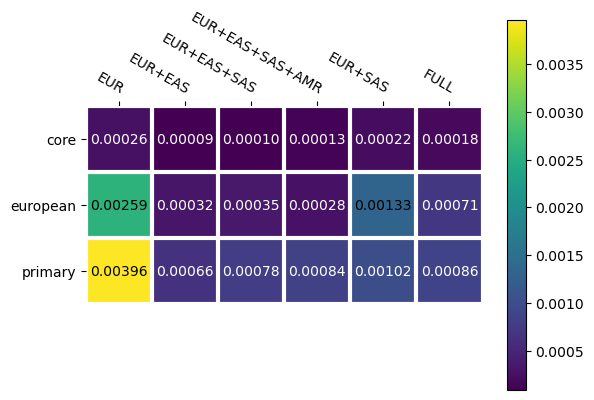

In [137]:
fig,ax = plt.subplots()

im,cbar = heatmap(pval.to_numpy(),row_labels=pval.index.tolist(),col_labels=pval.columns.tolist())
texts = annotate_heatmap(im,valfmt="{x:.5f}",threshold=.0013)

In [98]:
pval

ld,EUR,EUR+EAS,EUR+EAS+SAS,EUR+EAS+SAS+AMR,EUR+SAS,FULL
sum_stat,,,,,,
asian,-0.126813,13.755736,31.799105,38.534601,4.589720,14.399833
core,-258.273751,-271.111246,-265.575186,-263.270294,-255.680373,-255.770775
european,-216.139664,-248.931703,-245.551352,-250.363784,-223.280634,-231.491057
primary,-205.866820,-238.356966,-229.863080,-230.017659,-228.802336,-228.083502


In [166]:
euro_result[euro_result['PRS_pval']<0.05].sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
117,Imperial 80,30254.539718,0.000000e+00,110.363455,0.484151,11.203485,0.899955,-1720.245182,5.051947e-30,4347.964561,1.062085e-106,-31.513553,0.734802,139.515753,0.119260,-57.550719,0.445535,-202.261160,0.005519,SCZ_PRS_EUR_SCORESUM_CSx
116,Imperial 79,30107.899666,0.000000e+00,225.638486,0.160442,46.010895,0.612018,-1778.113616,9.936890e-31,4358.415879,3.245862e-105,-56.616563,0.549943,76.175099,0.402528,-12.221830,0.873457,-204.048050,0.005939,SCZ_PRS_EUR_SCORESUM_CSx
54,Imperial 79,30108.946335,0.000000e+00,223.596029,0.165624,49.589200,0.585325,-1783.043727,9.090764e-31,4361.233078,4.831147e-105,-57.748368,0.542876,75.666726,0.407324,-15.184633,0.843382,-188.327260,0.011353,SCZ_PRS_META_SCORESUM_CSx
55,Imperial 80,30255.063900,0.000000e+00,109.340571,0.489905,14.852985,0.867954,-1725.225209,4.885663e-30,4350.515413,1.855301e-106,-33.004107,0.723512,138.153842,0.124449,-60.765419,0.421581,-181.989597,0.012820,SCZ_PRS_META_SCORESUM_CSx
81,Imperial 22,12448.457549,3.320708e-263,-116.445813,0.343895,109.254558,0.116658,283.159777,6.883147e-03,1793.840443,7.558310e-53,-52.059003,0.473069,62.027256,0.373612,-4.235739,0.942557,123.929108,0.028756,SCZ_PRS_EUR_SCORESUM_CSx
19,Imperial 22,12447.771976,5.664993e-263,-115.107993,0.350622,107.091229,0.124406,286.145048,6.378649e-03,1792.105927,1.125786e-52,-51.407420,0.479199,62.252651,0.373156,-2.463270,0.966599,114.836598,0.043258,SCZ_PRS_META_SCORESUM_CSx


/home/lh20/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lh20/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lh20/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lh20/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Text(0, 0.5, '')

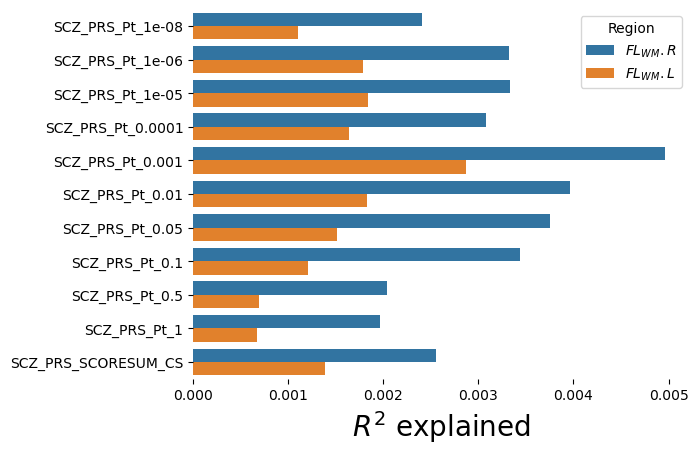

In [615]:
fig,bar_plot = plt.subplots(1,1)
#draw the barplot of R-squared explained
dependent_var=['Imperial 79','Imperial 80']
Rsquared_explained_list = defaultdict(dict)
for dependent_variable in dependent_var:
    Rsquared_explained_list[dependent_variable] = defaultdict(list)
    for threshold in [i for i in df.columns if 'PRS' in i]:
        Rsquared_explained_list[dependent_variable][threshold] = stats.MassUnivariate.calculate_R_squared_explained(df = df,
    col_to_drop=threshold,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV',threshold]+ancestry,
    dependentVar_cols=[dependent_variable])
        
Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_list)
Rsquared_explained_pd.columns = ['$FL_{WM}.R$','$FL_{WM}.L$']

Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_pd.unstack()).reset_index()
Rsquared_explained_pd.columns = ['Region','Threshold','$R^{2}$ explained']

g = sns.barplot(y = 'Threshold',x = '$R^{2}$ explained', data = Rsquared_explained_pd,hue = 'Region',ax = bar_plot)
# g.set_xlabel(rotation=90)
sns.despine(bottom=True,left=True,right=True)
bar_plot.set_xlabel('$R^{2}$ explained',fontsize=20)
bar_plot.set_ylabel(None,fontsize=20)

In [88]:
# ancestry = [i for i in df.columns if 'euro_Anc' in i]
# euro_all_models = stats.MassUnivariate.check_all_predictors_combo_linear_Reg(df,
#                                                                              cat_independentVar_cols=['sex'],
#                                                 cont_independentVar_cols=['GA','PMA',
#                                                 'TBV','SCZ_PRS_Pt_0.001_LD_EUR_stat_core']+ ancestry,
#                                                 dependentVar_cols=["Imperial 79"],
#                                                 check_plan='sequential',
#                                                 check_cols=ancestry,scaling=None)
# euro_model_score,_,_,euro_model_p = stats.MassUnivariate.preprocess_forward_selection(euro_all_models)
# ancestry = [i for i in df.columns if 'euro_Anc' in i]
# mixed_all_models = stats.MassUnivariate.check_all_predictors_combo_linear_Reg(df,
#                                                                              cat_independentVar_cols=['sex'],
#                                                 cont_independentVar_cols=['GA','PMA',
#                                                 'TBV','SCZ_PRS_Pt_0.001_LD_EUR_stat_core']+ ancestry,
#                                                 dependentVar_cols=["Imperial 79"],
#                                                 check_plan='sequential',
#                                                 check_cols=ancestry,scaling=None)
# mixed_model_score,_,_,mixed_model_p = stats.MassUnivariate.preprocess_forward_selection(mixed_all_models)
# euro_model_score['PRS_pval'] = euro_model_p["standardize(Q('SCZ_PRS_Pt_0.001_LD_EUR_stat_core'))"]
# euro_model_score['N_var']  = euro_model_score['N_var'] - 5
# mixed_model_score['PRS_pval'] = mixed_model_p["standardize(Q('SCZ_PRS_Pt_0.001_LD_EUR_stat_core'))"]
# mixed_model_score['N_var']  = mixed_model_score['N_var'] - 5
# fig,axes = plt.subplots(1,2,figsize=(15,5))
# axes = axes.flatten()
# data_euro = euro_model_score.copy()
# visualisation.SimplePlots.Bar(x='N_var',
#                               y='PRS_pval',
#                               data=data_euro,yscalelog=False,
#                               order = {'x':[str(i) for i in range(1,11)]},alpha=0.5,hline=0.0009,
#                               ax = axes[0])
# axes[0].tick_params(which='both',axis='y',colors='b')
# axes[0].set_ylabel('$PRS p-value$',color='b')
# ax2 = axes[0].twinx()
# ax2.plot(data_euro['N_var'],data_euro['AIC'],'or-',alpha=0.5)
# ax2.set_yscale('log')
# ax2.tick_params(which='both',axis='y',colors='r')
# ax2.set_ylabel('AIC',color='r')
# axes[0].set_title('EUR cohort ancestry PCs')

# data_mixed = mixed_model_score.copy()

# visualisation.SimplePlots.Bar(x='N_var',
#                               y='PRS_pval',
#                               data=data_mixed,yscalelog=False,
#                               order = {'x':[str(i) for i in range(1,11)]},alpha=0.5,hline=0.0009,
#                               ax = axes[1])
# ax2 = axes[1].twinx()
# ax2.plot(data_mixed['N_var'],data_mixed['AIC'],'or-',alpha=0.5)
# axes[1].tick_params(which='both',axis='y',colors='b')
# axes[1].set_ylabel('$PRS p-value$',color='b')
# ax2.set_yscale('log')
# ax2.set_ylabel('AIC',color='r')
# ax2.tick_params(which='both',axis='y',colors='r')
# ax2.set_ylabel('AIC',color='r')
# axes[1].set_title('EUR+SAS cohort ancestry PCs')
# sns.despine(top=True,right=False)
# plt.tight_layout()
# axes[0].get_legend().set_visible(False)
# axes[1].get_legend().set_visible(False)

# fig.savefig('./ancestry_PCs.png')

In [16]:
# def group_split(job):
#     groups = stats.Stability_tests.split_group(df,n=2)
#     for gr_idx,group in enumerate(groups):
#         _, european_mass_univariate_group = stats.MassUnivariate.mass_univariate(
#                 group,
#                 cat_independentVar_cols=['sex'],
#                 cont_independentVar_cols=['SCZ_PRS_Pt_0.001_LD_EUR_stat_core','PMA','GA','TBV']+ancestry,
#                 dependentVar_cols=['Imperial 79'],scaling='both')
                
# #         european_mass_univariate_group = european_mass_univariate_group.sort_values(by="standardize(Q('PRS_pca'))_pval").head(1)
        
#         european_mass_univariate_group['group'] = gr_idx
#         european_mass_univariate_group['random_state'] = job
#         test_file='stability_test_SCZ_mixed.csv'
#         european_mass_univariate_group.to_csv(test_file,mode='a',header=not os.path.exists(test_file))
        
# from joblib import Parallel, delayed
# import time
# import tqdm
# import glob
# import os
# start=time.time()
# tasks = [delayed(group_split)(i) for i in range(1000)]
# Parallel(n_jobs=-1)(tqdm.tqdm(tasks))
# end = time.time()
# print((end-start))

# stability_test_mixed = pd.read_csv('stability_test_SCZ_mixed.csv')
# stability_test_mixed = stability_test_mixed.dropna()
# stability_test_mixed = stability_test_mixed.drop(columns=stability_test_mixed.columns[0])
# stability_test_mixed = stability_test_mixed[["standardize(Q('SCZ_PRS_Pt_0.001_LD_EUR_stat_core'))_coef",
#                                  "standardize(Q('SCZ_PRS_Pt_0.001_LD_EUR_stat_core'))_pval",
#                                  'random_state','group']].sort_values(by='random_state').copy()
# stability_test_mixed['coef'] = stability_test_mixed[["standardize(Q('SCZ_PRS_Pt_0.001_LD_EUR_stat_core'))_coef"]].astype('float')
# stability_test_mixed['pval'] = stability_test_mixed[["standardize(Q('SCZ_PRS_Pt_0.001_LD_EUR_stat_core'))_pval"]].astype('float')
# stability_test_count_nominal = pd.DataFrame(stability_test_mixed.groupby('random_state')['pval'].apply(lambda x: (x<0.05).sum()))
# stability_test_count_significant = pd.DataFrame(stability_test_mixed.groupby('random_state')['pval'].apply(lambda x: (x<0.0009).sum()))
# stability_test_count_mixed = pd.concat([stability_test_count_nominal,stability_test_count_significant],axis=1)
# stability_test_count_mixed.columns = ['pval<0.05','pval<0.0009']
# stability_test_euro['group'] = stability_test_euro['group']+1
# stability_test_mixed['group'] = stability_test_mixed['group']+1
# fig,axes = plt.subplots(2,2,figsize=(20,10))
# axes = axes.flatten()
# g = sns.violinplot(y="coef",x='group',data=stability_test_euro,ax=axes[0])
# axes[0].axhline(-0.0746,c='r',label='observed')
# axes[0].legend()
# g = sns.histplot(data=stability_test_count_euro,x='pval<0.05',hue='pval<0.0009',shrink=0.5,
#                 discrete=True,multiple='stack',ax=axes[1])
# g = sns.violinplot(y="coef",x='group',data=stability_test_mixed,ax=axes[2])
# axes[2].axhline(-0.0788,c='r',label='observed')
# axes[2].legend()
# g = sns.histplot(data=stability_test_count_mixed,x='pval<0.05',hue='pval<0.0009',shrink=0.5,
#                 discrete=True,multiple='stack',ax=axes[3])
# for ax,number in zip(axes,['A','B','C','D']):
#     ax.text(-0.15,1, number, transform=ax.transAxes, fontsize=15, fontweight='bold')
# sns.despine()
# axes[0].set_title('Distribution of standardised beta in two randomly split groups: EUR cohort (n=277)')
# axes[1].set_title('Count of nominally and statistically significant results \n in each random iteration: EUR cohort (n=277)')
# axes[2].set_title('Distribution of standardised beta in two randomly split groups: EUR+SAS cohort (n=332)')
# axes[3].set_title('Count of nominally and statistically significant results \n in each random iteration: EUR+SAS cohort (n=332)')
# axes[0].set_ylabel('standardised beta coef')
# axes[2].set_ylabel('standardised beta coef')
# plt.tight_layout()
# fig.savefig('stability_test_SCZ.png')

In [79]:
# test = stats.MassUnivariate.adjust_covariates_with_lin_reg(df.copy(),
#                                                    cont_independentVar_cols=ancestry,
#                                                    dependentVar_cols=[i for i in df.columns if 'SCZ_PRS' in i])

# from scipy.stats import wilcoxon, ttest_ind
# thresholds = [thr for thr in df.columns if 'SCZ_PRS' in thr]
# all_combo = pd.DataFrame()
# p_val = pd.DataFrame()
# for threshold in thresholds:
#     for perc in [0.1,0.2,0.3,0.4]:
#         high_risk,low_risk = stats.Stability_tests.divide_high_low_risk(test[threshold],high_perc=perc,low_perc=perc)
#         adjusted_df = stats.MassUnivariate.adjust_covariates_with_lin_reg(
#             df,cat_independentVar_cols=['sex'],
#             cont_independentVar_cols=['GA','PMA','TBV'],
#             dependentVar_cols=['Imperial 79'])
#         adjusted_df['risk'] = ['high' if i in high_risk else 'low' if i in low_risk else np.nan for i in adjusted_df.index.tolist()]
#         adjusted_df['threshold'] = threshold
#         adjusted_df['percentage'] = perc
#         all_combo = pd.concat([all_combo,adjusted_df.dropna()])
#         temp_pval = pd.DataFrame()

#         temp_pval['threshold'] = [threshold]
#         temp_pval['percentage'] = [perc]
#         for i in ['Imperial 79']:
#             st,pval = ttest_ind(adjusted_df.loc[adjusted_df['risk']=='high',i].values,
#                      adjusted_df.loc[adjusted_df['risk']=='low',i].values)
#             temp_pval[i+'_pval'] = pval
#             temp_pval[i+'_stat'] = st
#         p_val = pd.concat([p_val,temp_pval])
# all_combo = all_combo.reset_index(drop=True)

# # all_combo_euro = all_combo.copy()
# # p_val_euro = p_val.copy()

# all_combo_euro['threshold'] = all_combo_euro['threshold'].apply(lambda x: x.split('_')[3])
# all_combo_mixed['threshold'] = all_combo_mixed['threshold'].apply(lambda x: x.split('_')[3])

# p_val_euro['threshold'] = p_val_euro['threshold'].apply(lambda x: x.split('_')[3])
# p_value_mixed['threshold'] = p_value_mixed['threshold'].apply(lambda x: x.split('_')[3])

# fig,axes = plt.subplots(2,2,figsize=(15,10))
# axes = axes.flatten()

# visualisation.SimplePlots.Box(x='threshold',
#                               y='Imperial 79',
#                               hue='risk',
#                               data=all_combo_euro[all_combo_euro['percentage']==0.3],ylabel='Adj(Brain volume)',
#                               order=thresholds,rotation_x=90,title='Comparison between top and bottom 30% based on PRS \n in EUR cohort',
#                              ax=axes[0])

# visualisation.SimplePlots.Bar(x='threshold',
#                               y='Imperial 79_pval',
#                               data=p_val_euro[p_val_euro['percentage']==0.3],
#                               ylabel='$log_{10}(pval)$',
#                               hline=0.05,
#                               hline_label='p-val<0.05',
#                               order={'x':thresholds},rotation_x=90,title='Imperial 79',
#                              ax=axes[1],legend_loc='upper left',xlabel=None)

# visualisation.SimplePlots.Box(x='threshold',
#                               y='Imperial 79',
#                               hue='risk',
#                               data=all_combo_mixed[all_combo_mixed['percentage']==0.3],ylabel='Adj(Brain volume)',
#                               order=thresholds,rotation_x=90,title='Comparison between top and bottom 30% based on PRS \n in EUR+SAS cohort',
#                              ax=axes[2])

# visualisation.SimplePlots.Bar(x='threshold',
#                               y='Imperial 79_pval',
#                               data=p_value_mixed[p_value_mixed['percentage']==0.3],
#                               ylabel='$log_{10}(pval)$',
#                               hline=0.05,
#                               hline_label='p-val<0.05',
#                               order={'x':thresholds},rotation_x=90,title='Imperial 79',
#                              ax=axes[3],legend_loc='upper left',xlabel=None)

# axes[1].set_yscale('log')
# axes[3].set_yscale('log')
# axes[0].tick_params(axis='x',which='both',labelbottom=False)
# axes[1].tick_params(axis='x',which='both',labelbottom=False)
# for ax,number in zip(axes,['A','B','C','D']):
#     ax.text(-0.15,1, number, transform=ax.transAxes, fontsize=15, fontweight='bold')

# plt.tight_layout()
# sns.despine()
# fig.savefig('stability_test_scz_box.png')